In [1]:
%matplotlib inline
import os
os.environ['PY3_PROD'] = '1'
%load_ext autoreload
%autoreload 2
os.system('kinit')

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import copy
import numpy as np
import math
import matplotlib as mpl
import matplotlib.dates as dates
import matplotlib.pyplot as plt
import datetime
import itertools
import pandas as pd

from pycmqlib3.utility import dbaccess, dataseries, misc
import pycmqlib3.analytics.data_handler as dh


import sys
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

sys.path.append("C:/dev/pyktrader3/")
sys.path.append("C:/dev/wtpy/")
sys.path.append("C:/dev/akshare/")
sys.path.append("C:/dev/wtdev/")

from pycmqlib3.analytics.tstool import *
from pycmqlib3.analytics.btmetrics import *
from pycmqlib3.analytics.backtest_utils import *
from misc_scripts.fun_factor_update import *
from pycmqlib3.strategy.signal_repo import *
from bktest.backtest_grid_search import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mpl.rcParams['figure.figsize'] = (12, 8)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))
lead_lag_config = {
    'll_left': -20,
    'll_right': 120,
    'll_spacing': 5,
    'll_sub_win': [(datetime.date(2008, 1, 1), datetime.date(2016, 12, 31)), 
                   (datetime.date(2017, 1, 1), datetime.date(2022, 12, 31)),],
}

ll_keys = ['fullsample'] + ['%s:%s' % (sd.strftime('%Y-%b-%d'), ed.strftime('%Y-%b-%d')) for sd, ed in lead_lag_config['ll_sub_win']]


# product group and starting date

In [5]:
tday = datetime.date(2024,3,8)

df = load_cnc_fut(tday)
spot_df = load_fun_data(tday)

start_date = df.index[0]
end_date = tday

cdates = pd.date_range(start=start_date, end=tday, freq='D')
bdates = pd.bdate_range(start=start_date, end=end_date, freq='C', holidays=misc.CHN_Holidays)

asset_pairs = [('i', 'rb'), ('i', 'hc'), ('i', 'j'), ('j', 'jm'),]
beta_ret_dict = {}
betas_dict = {}
for trade_asset, index_asset in asset_pairs:
    asset_df = df[[(index_asset, 'c1', 'close'), (trade_asset, 'c1', 'close')]].copy(deep=True).droplevel([1,2], axis=1)
    asset_df = asset_df.dropna(subset=[trade_asset]).ffill()

    for asset in asset_df:
        asset_df[f'{asset}_pct'] = asset_df[asset].pct_change().rolling(5).mean()
    asset_df['beta'] = asset_df[f'{index_asset}_pct'].rolling(244).cov(asset_df[f'{trade_asset}_pct'])/asset_df[f'{index_asset}_pct'].rolling(244).var()
    key = '_'.join([trade_asset, index_asset])
    asset_df[key] = asset_df[trade_asset].pct_change() - asset_df['beta'] * asset_df[index_asset].pct_change().fillna(0)
    beta_ret_dict[key] = asset_df[key].dropna()
    betas_dict[key] = asset_df['beta']


# strategy portfolio config

In [6]:
# field_list = ['contract', 'open', 'high', 'low', 'close', 'volume', 'openInterest', 'diff_oi', 'expiry', 'mth', 'shift']

# start_date = datetime.date(2010,1,1)
# end_date = datetime.date(2023,1,20)
# shift_mode = 1
# roll_name = 'hot'
# roll_file_loc = "C:/dev/wtdev/config/"
# sim_markets = all_markets
# nb_cont = 2
# freq='d'

# data_df = pd.DataFrame()

# for prodcode in sim_markets:
#     for nb in range(nb_cont):
#         print("loading product = %s nb = %s" % (prodcode, nb))
#         xdf = dataseries.nearby(prodcode,
#                                   nb+1,
#                                   start_date=start_date, 
#                                   end_date=end_date, 
#                                   shift_mode=shift_mode,
#                                   freq=freq, 
#                                   roll_name=roll_name, 
#                                   config_loc=roll_file_loc)
#         xdf['expiry'] = xdf['contract'].map(misc.contract_expiry)
#         xdf['contmth'] = xdf['contract'].map(misc.inst2contmth)
#         xdf['mth'] = xdf['contmth'].apply(lambda x: x//100 * 12 + x % 100) 
#         xdf['product'] = prodcode
#         xdf['code'] = f'c{nb+1}'
#         data_df = data_df.append(xdf)

# df = pd.pivot_table(data_df.reset_index(), index='date', columns = ['product', 'code'], values = field_list, aggfunc = 'last')
# df = df.reorder_levels([1, 2, 0], axis=1).sort_index(axis=1)
# df.columns.rename(['product', 'code', 'field',], inplace = True)
# df.index = pd.to_datetime(df.index)

# print(df.tail(20))


In [6]:
scenarios_old = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
#     ('custom', 'hc_rb_diff', 2.9, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('custom', 'leader_lagger', 0.64, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),    
]

funda_w = 0.8
funda_b = 0.8
scenarios_prod = [
    ('tscarry', 'ryieldnmb', 0.1213, 1, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.2727, 1, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.0, 1, 60, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'ryieldqtl', 0.184, 1, 244, 1, (None, {}, ''), [0.0, 0.0]),

    ('tscarry', 'basmomnma', 0.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0103, 60, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.0532, 120, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomnma', 0.1204, 180, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.4054, 120, 20, 1, (None, {}, ''), [0.0, 0.0]),
    ('tscarry', 'basmomqtl', 0.3380, 240, 20, 1, (None, {}, ''), [0.0, 0.0]),
    
    #('xscarry-rank', 'ryieldnma', 0, 1, 20, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'ryieldnma', 1.102, 1, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xscarry-rank', 'ryieldnma', 0, 1, 244, 1, (None, {}, ''), [0.0, 0.0], 0.2),

    ('xscarry-rank', 'basmomnma', 0.5282, 20, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.1997, 100, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xscarry-rank', 'basmomnma', 0.4554, 170, 122, 1, (None, {}, ''), [0.0, 0.0], 0.2), 

    ('tsmom', 'hlbrk', 0.5546, 20, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 40, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.0, 61, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    #('tsmom', 'hlbrk', 0.000, 122, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),
    ('tsmom', 'hlbrk', 0.4524, 244, 1, 10, (None, {}, ''), [0.0, 0.0], 0.2),  
    ('tsmom', 'macdnma', 0.0, 8, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 10.0]),
    ('tsmom', 'macdnma', 0.0, 16, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 5.0]),
    ('tsmom', 'macdnma', 0.04414, 24, 160, 5, (response_curve, {"response": "reverting", "param": 2}, 'reverting'), [1.5, 3.34]),
    ('xsmom-rank', 'hlbrk', 0.1458, 20, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 40, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 61, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    #('xsmom-rank', 'hlbrk', 0.000, 122, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'hlbrk', 0.0, 244, 1, 1, (None, {}, ''), [0.0, 0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.2731, 10, 10, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.1708, 130, 120, 1, (None, {}, ''), [0.0], 0.2),
    ('xsmom-rank', 'momnma', 0.3562, 240, 60, 1, (None, {}, ''), [0.0], 0.2),
    ('custom', 'hc_rb_diff', 2.0, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
    ('custom', 'leader_lagger', 0.6, 40, 122, 1, (None, {}, ''), [0.0, 0.0]), 
    
    ('custom', 'long_break', 1, 2, 7, 1, (None, {}, ''), [0.0, 0.0]),  
    
    ('funda', 'io_removal_lvl', funda_w, 1, 1, 1, ['i',], None),
    ('funda', 'io_removal_lyoy', funda_w, 1, 1, 1, ['i', 'rb', 'hc',], None),    
    ('funda', 'io_millinv_lyoy', funda_w, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc',], None),
    ('funda', 'io_invdays_lyoy', funda_w*0.5, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None),
    ('funda', 'io_invdays_lvl', funda_w*0.5, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None),
    ('funda', 'strip_hsec_lvl_mid', funda_w, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'v', 'FG', 'SF', 'al'], None),
    ('funda', 'steel_margin_lvl_fast', funda_w, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'FG', 'SF'], None),         
    ('funda', 'steel_sinv_lyoy_zs', funda_w*0.5, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),
    ('funda', 'steel_sinv_lyoy_mds', funda_w*0.5, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),    
    ('funda', 'fef_c1_c2_ratio_or_qtl', funda_w*1.5, 1, 1, 1, ['rb', 'hc', 'j'], None),
    
    ('funda', 'rbhc_dmd_mds', 1*funda_w, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_dmd_lyoy_mds', 1*funda_w, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_sinv_mds', 1*funda_w, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'rbhc_sinv_lyoy_mds', 1*funda_w, 1, 1, 3, ['rb', 'hc'], None),
    ('funda', 'io_pinv45_lvl_hlr', 1*funda_w, 1, 1, 4, ['rb', 'hc', 'i'], None),
    ('funda', 'io_pinv31_lvl_zsa', 1*funda_w, 1, 1, 4, ['rb', 'hc', 'i'], None),
    ('funda', 'fef_c1_c2_ratio_spd_qtl', 1*funda_w, 1, 1, 4, ['rb', 'hc', 'j', 'i'], None),
    
    ('funda', 'lme_base_ts_mds', funda_b, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
    ('funda', 'lme_base_ts_hlr', funda_b, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
    ('funda', 'base_phybas_carry_ma', funda_b, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn'], None),
    ('funda', 'base_inv_mds', 1.5*funda_b, 1, 1, 0, ['cu', 'al', 'zn', 'ni'], None),
    
    ('funda', 'cu_prem_usd_zsa', funda_b, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_prem_usd_md', funda_b, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_phybasis_zsa', funda_b, 1, 1, 1, ['cu'], None),
    ('funda', 'cu_phybasis_hlr', funda_b, 1, 1, 1, ['cu'], None), 
]

scenarios_funda = [
#     ('custom', 'hc_rb_diff', 1, 20, 122, 1, (None, {}, ''), [0.0, 0.0]),
#     ('custom', 'leader_lagger', 1, 40, 122, 1, (None, {}, ''), [0.0, 0.0]),    
#     ('funda', 'io_removal_lvl', 1, 1, 1, 1, ['i',], None),
#     ('funda', 'io_removal_lyoy', 1, 1, 1, 1, ['i', 'rb', 'hc',], None),    
#     ('funda', 'io_millinv_lyoy', 1, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc',], None),
#     ('funda', 'io_invdays_lyoy', 1, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None),
#     ('funda', 'io_invdays_lvl', 1, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'SM', 'SF', 'v', 'FG', 'al'], None), 
#     ('funda', 'strip_hsec_lvl_mid', 1.0, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'v', 'FG', 'SF', 'al'], None),    
#     ('funda', 'steel_margin_lvl_fast', 1.0, 1, 1, 1, ['i', 'j', 'jm', 'rb', 'hc', 'FG', 'SF'], None),
#     ('funda', 'steel_sinv_lyoy_zs', 0.5, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),
#     ('funda', 'steel_sinv_lyoy_mds', 0.5, 1, 1, 1, ['i', 'rb', 'hc', 'v', 'FG'], None),   
#     ('funda', 'fef_c1_c2_ratio_or_qtl', 1.5, 1, 1, 1, ['rb', 'hc', 'j'], None),
    
#     ('funda', 'rbhc_dmd_mds', 1, 1, 1, 3, ['rb', 'hc'], None),
#     ('funda', 'rbhc_dmd_lyoy_mds', 1, 1, 1, 3, ['rb', 'hc'], None),
#     ('funda', 'rbhc_sinv_mds', 1, 1, 1, 3, ['rb', 'hc'], None),
#     ('funda', 'rbhc_sinv_lyoy_mds', 1, 1, 1, 3, ['rb', 'hc'], None),    
#     ('funda', 'io_pinv45_lvl_hlr', 1, 1, 1, 4, ['rb', 'hc', 'i'], None),
#     ('funda', 'io_pinv31_lvl_zsa', 1, 1, 1, 4, ['rb', 'hc', 'i'], None),
#     ('funda', 'fef_c1_c2_ratio_spd_qtl', 1, 1, 1, 4, ['rb', 'hc', 'j', 'i'], None),
    ('funda', 'metal_pbc_ema', 1, 1, 1, 0, 
     ['cu', 'al', 'zn', 'pb', 'ni', 'ss', 'sn', 'ao', 'rb', 'hc', 'i', 'j', 'jm', 'v', 'FG'], None),
    ('funda', 'metal_pbc_ema_xdemean', 1, 1, 1, 0, 
     ['cu', 'al', 'zn', 'pb', 'ni', 'ss', 'sn', 'ao', 'rb', 'hc', 'i', 'j', 'jm', 'v', 'FG'], None),    
    ('funda', 'metal_inv_hlr', 1, 1, 1, 0, 
     ['cu', 'al', 'zn', 'pb', 'ni', 'ss', 'sn', 'ao', 'si', 'rb', 'hc', 'i', 'j', 'jm', 'SM', 'SF', 'v', 'FG'], None),
    ('funda', 'metal_inv_hlr_xdemean', 1, 1, 1, 0, 
     ['cu', 'al', 'zn', 'pb', 'ni', 'ss', 'sn', 'ao', 'si', 'rb', 'hc', 'i', 'j', 'jm', 'SM', 'SF', 'v', 'FG'], None),
    ('funda', 'metal_inv_lyoy_hlr', 1, 1, 1, 0, 
     ['cu', 'al', 'zn', 'pb', 'ni', 'ss', 'sn', 'ao', 'si', 'rb', 'hc', 'i', 'j', 'jm', 'SM', 'SF', 'v', 'FG'], None),
    
#     ('funda', 'lme_base_ts_mds', 1, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
#     ('funda', 'lme_base_ts_hlr', 1, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn', 'pb'], None),
#     ('funda', 'base_phybas_carry_ma', 1.25, 1, 1, 0, ['cu', 'al', 'zn', 'ni', 'sn'], None),
#     ('funda', 'base_inv_mds', 1.5, 1, 1, 0, ['cu', 'al', 'zn', 'ni'], None),
    
#     ('funda', 'cu_prem_usd_zsa', 0.5, 1, 1, 1, ['cu'], None),
#     ('funda', 'cu_prem_usd_md', 0.5, 1, 1, 1, ['cu'], None),
#     ('funda', 'cu_phybasis_zsa', 0.5, 1, 1, 1, ['cu'], None),
#     ('funda', 'cu_phybasis_hlr', 0.7, 1, 1, 1, ['cu'], None),    
]



In [8]:
#signal_ts = long_break(df, {'days': 2, 'gaps':7, 'product_list': product_list})


# run backtest for a portfolio group

In [7]:
scen_names = {}
scen_metrics = {}
scen_stats = {}
bt_empirics = {}
holdings = {}

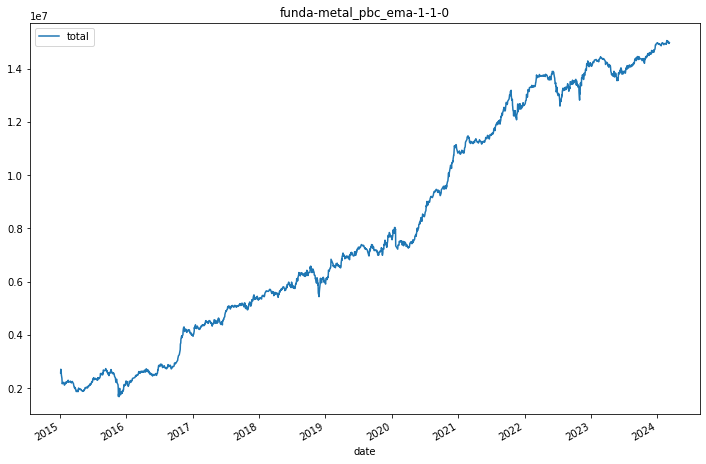

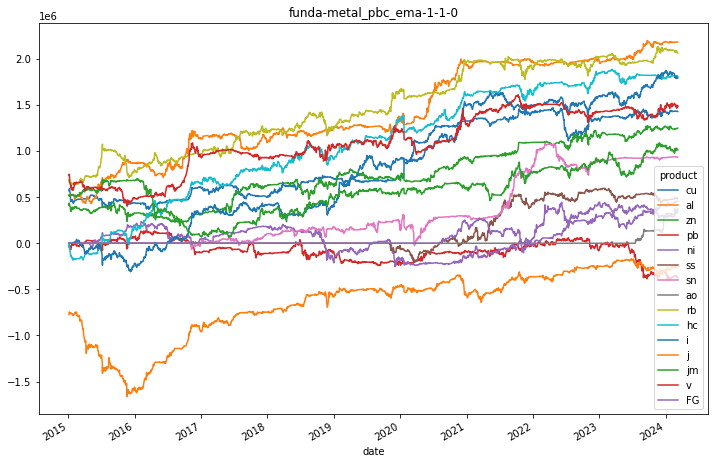

       sharpe       std  sortino
tenor                           
all      1.37  53349.53     1.92
6m       2.12  40179.68     3.96
1y       0.80  48891.63     1.41
2y       0.67  63835.08     1.08
3y       1.22  65942.71     1.86
4y       1.92  63932.97     2.99
5y       1.63  65536.13     2.29
6y       1.52  65738.44     2.16
7y       1.55  62770.31     2.19
8y       1.65  60605.73     2.34
9y       1.54  59235.15     2.16
10y      1.36  58089.11     1.92
11y      1.41  56198.72     1.97
product       cu    al    zn    pb    ni    ss    sn    ao    rb    hc     i  \
sharpe      0.73  0.98  0.62 -0.23  0.23  0.65  0.74  3.14  0.90  0.99  1.01   
sharpe_6m   0.07  0.49  0.30 -0.25 -1.48 -1.09  0.15  2.83  0.96 -0.25  1.23   
sharpe_1y   0.41  1.39  0.52 -1.84 -0.28 -0.63  0.91  3.14  0.15 -0.46  0.87   
sharpe_2y  -0.05  1.14  0.43 -0.97 -0.06 -0.23 -0.55  3.14  0.26  0.25  0.71   
sharpe_3y   0.15  0.71  0.68 -0.56  0.85  0.84  1.28  3.14  0.16  0.39  0.51   
sharpe_4y   0.76  1.59  0

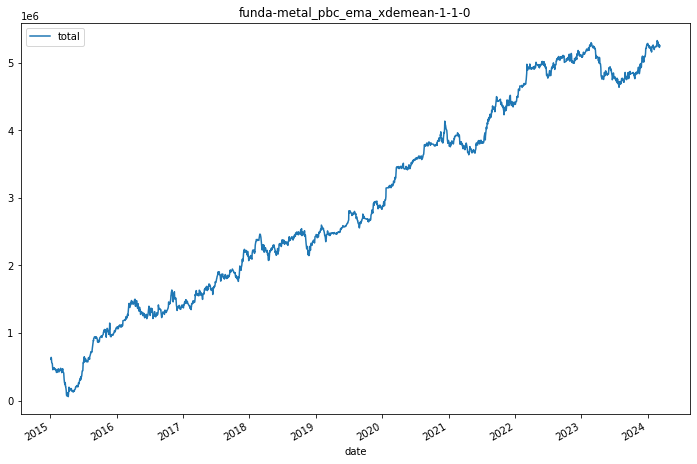

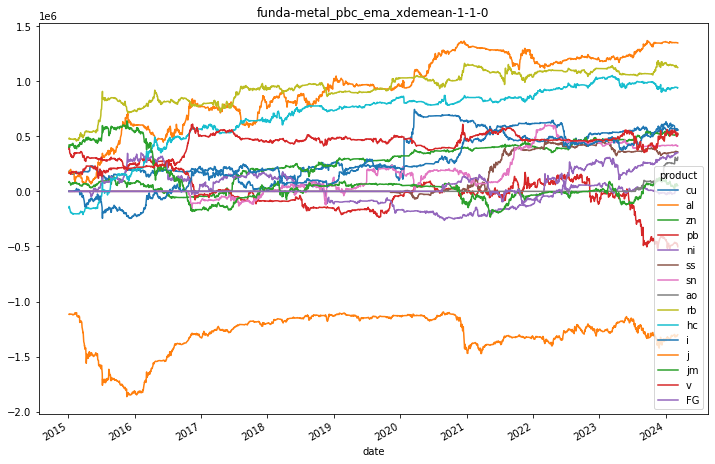

       sharpe       std  sortino
tenor                           
all      1.01  25428.25     1.52
6m       2.34  28330.18     3.74
1y       0.04  30429.82     0.07
2y       0.45  28579.97     0.71
3y       1.08  28969.36     1.77
4y       1.16  27894.95     1.88
5y       1.32  26741.30     2.12
6y       1.13  27287.98     1.78
7y       1.27  27174.06     2.03
8y       1.13  27378.31     1.79
9y       1.26  27201.50     2.00
10y      1.15  27435.89     1.78
11y      1.08  27043.53     1.68
product       cu    al    zn    pb    ni    ss    sn    ao    rb    hc     i  \
sharpe      0.28  0.64  0.40 -0.27  0.01  0.73  0.36  3.10  0.69  0.71  0.47   
sharpe_6m  -0.14  0.40  0.07 -0.23 -0.53 -0.36  0.47  2.94  0.80 -0.74  0.86   
sharpe_1y   0.29  1.36  0.62 -1.87 -0.11 -0.75 -0.54  3.10 -0.03 -0.86  0.50   
sharpe_2y  -0.30  1.21  0.62 -1.11 -0.37 -0.61 -1.26  3.10  0.14  0.07  0.34   
sharpe_3y  -0.15  0.13  0.41 -0.66  0.59  0.88  1.05  3.10 -0.03  0.30  0.23   
sharpe_4y   0.05  0.74  0

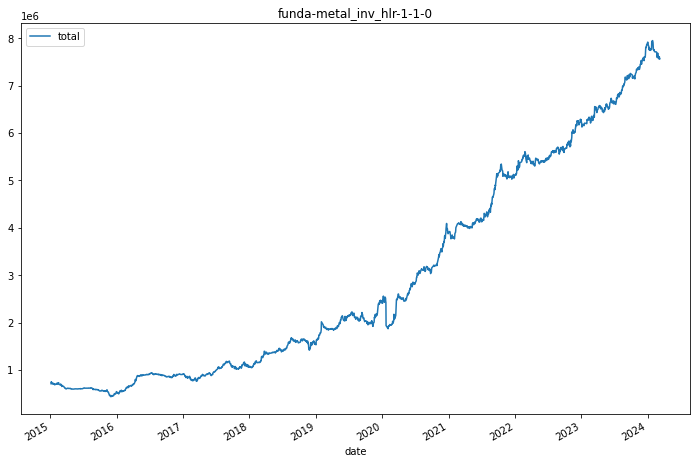

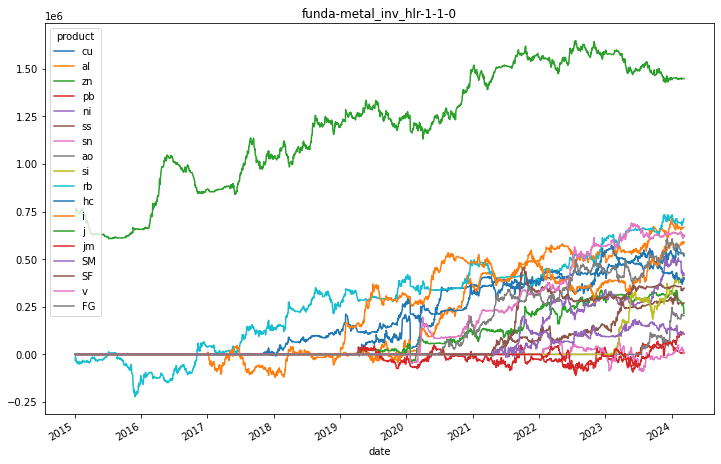

       sharpe       std  sortino
tenor                           
all      1.52  24347.34     1.79
6m       1.45  38264.12     2.55
1y       2.37  34976.20     4.22
2y       2.09  33563.40     3.66
3y       2.17  34273.77     3.69
4y       2.57  33652.80     4.38
5y       2.04  35865.70     2.59
6y       2.00  33978.51     2.55
7y       1.94  31890.47     2.43
8y       1.84  30043.92     2.28
9y       1.73  28459.32     2.13
10y      1.58  27458.41     1.96
11y      1.55  26416.41     1.91
product       cu    al    zn    pb    ni    ss    sn    ao    si    rb    hc  \
sharpe      0.46  0.65  0.25  0.01  0.63  0.80  0.02  1.82  2.12  0.50  0.53   
sharpe_6m  -0.13  0.42 -2.06 -0.67  1.72  0.18  0.81  1.22  1.61  0.88 -1.14   
sharpe_1y   0.41  1.03 -1.27  0.42  0.97  1.01 -0.06  1.82  2.09  1.28 -1.25   
sharpe_2y   0.48  0.52  0.02  0.12  0.59  1.14 -0.26  1.82  2.12  1.41 -0.19   
sharpe_3y   0.30  0.72  0.24  0.07  1.10  0.97  0.03  1.82  2.12  0.83  0.16   
sharpe_4y   0.91  1.33  0

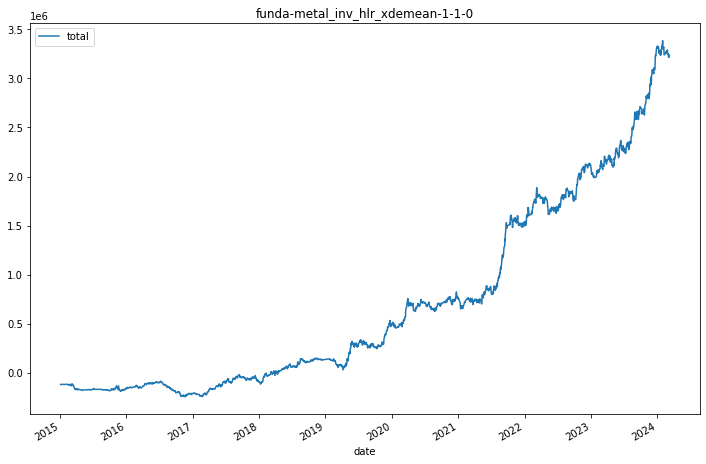

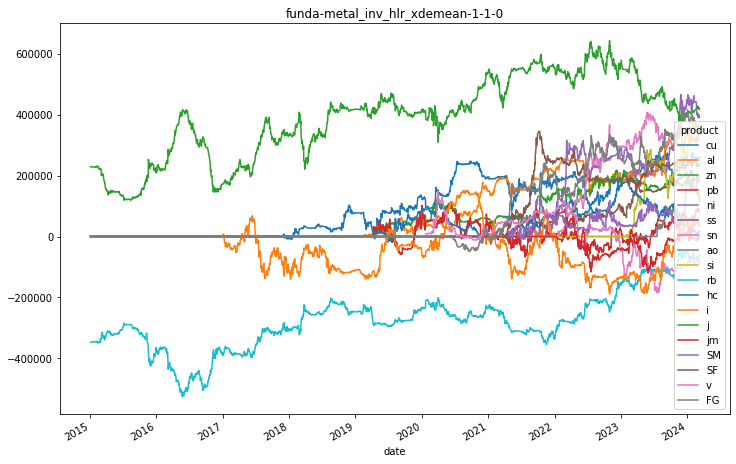

       sharpe       std  sortino
tenor                           
all      1.19  13245.55     1.62
6m       2.89  29226.15     5.17
1y       2.75  27143.01     4.84
2y       1.88  24101.54     3.15
3y       2.26  23682.46     3.92
4y       2.00  21737.50     3.34
5y       2.00  20321.53     3.30
6y       1.85  18771.50     2.91
7y       1.80  17586.66     2.75
8y       1.64  16547.13     2.46
9y       1.53  15690.20     2.24
10y      1.41  14987.94     2.03
11y      1.35  14402.68     1.93
product       cu    al    zn    pb    ni    ss    sn    ao    si    rb    hc  \
sharpe      0.34  0.49  0.20  0.00  0.58  0.76 -0.17  1.99  1.82 -0.06  0.03   
sharpe_6m   0.03  0.85 -1.82 -0.46  2.08  0.85  0.73  1.43  1.58  1.13 -1.36   
sharpe_1y   0.48  1.24 -1.42  0.29  1.14  1.18 -0.18  1.99  1.83  1.37 -1.65   
sharpe_2y   0.31  0.43 -0.02 -0.10  0.46  1.08 -0.65  1.99  1.82  1.51 -0.65   
sharpe_3y   0.21  0.55  0.19 -0.01  1.00  0.93 -0.27  1.99  1.82  0.91 -0.02   
sharpe_4y   0.40  0.90  0

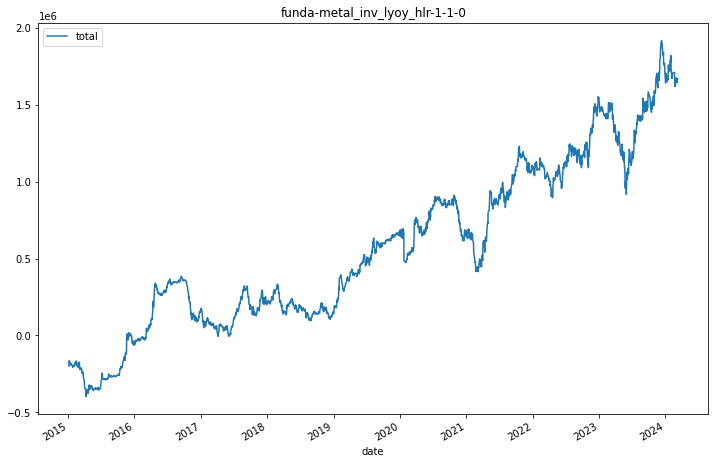

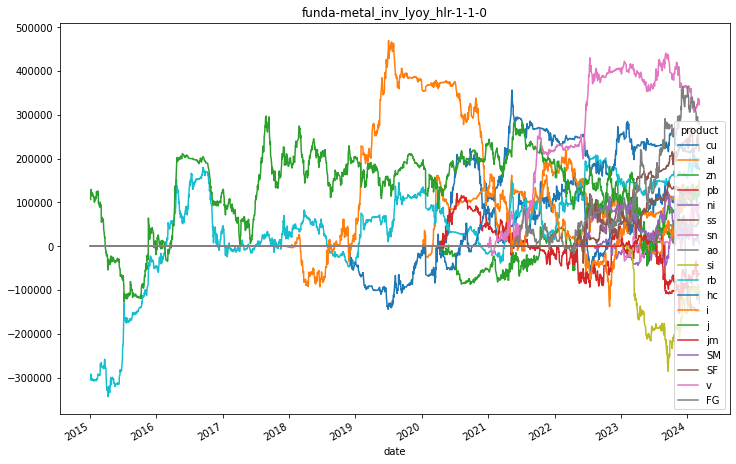

       sharpe       std  sortino
tenor                           
all      0.48  17082.89     0.60
6m       0.82  31308.59     1.34
1y       0.37  31829.25     0.62
2y       0.64  29154.45     1.08
3y       0.99  27147.91     1.64
4y       0.69  25347.20     1.13
5y       0.71  24038.56     1.03
6y       0.67  22488.76     0.95
7y       0.68  21496.16     0.96
8y       0.63  20632.74     0.88
9y       0.68  19907.61     0.95
10y      0.52  19417.61     0.73
11y      0.50  18654.20     0.69
product       cu    al    zn    pb    ni    ss    sn    ao    si    rb    hc  \
sharpe      0.14  0.19  0.08 -0.18  0.19  0.94  0.33 -1.27 -0.56  0.15  0.24   
sharpe_6m  -0.05  1.01  0.68 -1.04  1.69  1.05  1.44 -2.20  1.50  1.42 -1.29   
sharpe_1y   0.72  0.96 -0.41 -0.89  0.88  1.50  0.99 -1.27 -0.37  0.68 -0.66   
sharpe_2y  -0.14 -0.31  0.24 -0.52  0.39  1.41  0.63 -1.27 -0.56  0.55 -0.44   
sharpe_3y   0.30  0.37  0.39 -0.49  0.32  1.15  0.52 -1.27 -0.56  0.74  0.12   
sharpe_4y   0.25  0.27  0

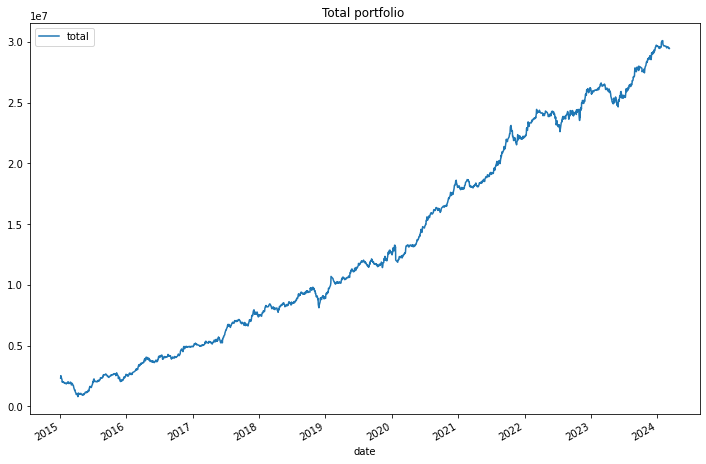

       sharpe        std  sortino
tenor                            
all      1.44   81509.53     1.84
6m       2.17  111067.89     3.78
1y       1.58  126037.94     2.72
2y       1.27  134690.42     2.18
3y       1.85  131302.80     3.06
4y       2.24  121927.80     3.62
5y       2.04  120712.67     2.93
6y       1.94  117008.95     2.81
7y       1.99  112281.16     2.88
8y       1.96  107164.34     2.82
9y       1.92  102939.01     2.75
10y      1.73  100347.94     2.50
11y      1.69   97079.94     2.44
pnl per trade: product
rb      94.659108
hc     186.970135
i      355.896990
j       14.579859
jm     105.241035
FG     357.657959
SM      48.790670
SF     334.725740
cu      62.580144
al      85.181378
zn      62.990105
ni     131.353703
sn     133.031863
ss     513.411362
si    2990.811547
dtype: float64, turnover: product
rb     8.857085
hc     8.096412
i      5.888932
j      8.323344
jm     5.508186
FG     7.703898
SM     8.168395
SF    10.235142
cu     7.667078
al     6.250550
zn 

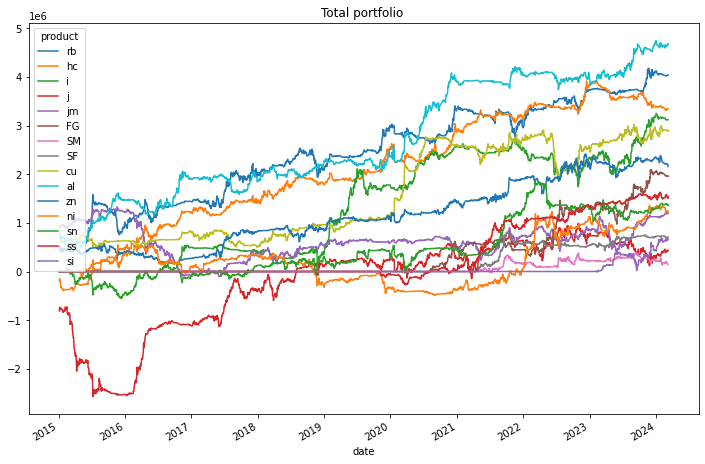

product           rb        hc         i         j        jm        FG  \
sharpe      0.682131  0.910451  0.764059  0.072375  0.292949  0.708411   
sharpe_6m   1.266528 -1.405407  1.856317 -0.014987  2.474388  0.887189   
sharpe_1y   0.832538 -1.572059  1.123303 -0.718587  0.356204  1.157578   
sharpe_2y   0.984665 -0.209698  0.720553  0.075740  0.338618  1.415650   
sharpe_3y   0.612364  0.321236  0.411396  0.235150  0.485755  1.046887   
sharpe_4y   0.751444  0.776949  0.800666  0.228869  0.382467  1.189704   
sharpe_5y   0.856092  0.817241  0.896937  0.094536  0.328574  1.063596   
sharpe_6y   0.825108  0.821332  0.973412  0.221205  0.390884  0.970617   
sharpe_7y   0.879110  0.850685  0.861488  0.433156  0.506037  0.897884   
sharpe_8y   0.874433  0.946098  0.959134  0.658431  0.105003  0.839596   
sharpe_9y   0.891721  1.151332  0.836026  0.342373  0.063414  0.791181   
sharpe_10y  0.689407  0.910451  0.778389  0.223466  0.188468  0.750586   
sharpe_11y  0.707479  0.910451  0.7640

In [13]:
file_folder = "C:\\dev\\data\\data_cache\\"

start_date = datetime.date(2011,1,1)
end_date = datetime.date.today()

scenario_map = {
    'old': scenarios_old,
    'prod': scenarios_prod,
    'funda': scenarios_funda,
}

roll_name = 'hot'
shift_mode = 2
rev_char = '!'
exec_mode = 'open'
unit_risk = 10_000
asset_scaling = False
std_win = 20
pnl_tenors = ['6m', '1y', '2y', '3y', '4y', '5y', '6y', '7y', '8y', '9y', '10y', '11y']

# product_list = product_grouping_partial['ind'] + product_grouping_partial['petro'] + product_grouping_partial['ags']
# product_list = product_grouping_complete['ind'] + product_grouping_complete['petro'] + product_grouping_complete['ags']

product_list = [
    'rb', 'hc', 'i', 'j', 'jm', 'FG', 'SM', 'SF', 'cu', 'al', 'zn', 'ni', 'sn', 'ss', 'si', #'bc'
    #'ru', 'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', 
    #'AP', 'eb', 'eg', 'UR', 'lu', 'lh', 
]
# product_list = [
#     #'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'SM', 'SF', 'al', 
#     'cu', 'zn', 'ni', 'sn', 'pb', 'al'
#     #'cu'
# ]

# product_list = ind_all_mkts + ags_all_mkts
# ind_all_mkts = ind_metal_mkts, petro_chem_mkts, ags_all_mkts = ags_oil_mkts + ags_soft_mkts

#scenario_name = 'old'
scenario_name = 'funda'

run_key = f'{roll_name}_{scenario_name}'
scenarios = scenario_map[scenario_name]

run_pos_sum = True
pos_sum = pd.DataFrame(0, index=df.index, columns=product_list)
scen_names[run_key] = []
scen_metrics[run_key] = []
scen_stats[run_key] = []

port_start = pd.to_datetime('2015-01-01')

for scen in scenarios:
    sim_type = scen[0]
    signal_name = scen[1]
    weight = scen[2]
    win = scen[3]
    ma_win = scen[4]
    rebal = scen[5]
    pos_map = scen[6]
    params = scen[7]
    run_name = '-'.join([sim_type, signal_name, str(win), str(ma_win), str(rebal)])
    
    run_args = {}
    run_args['shift_mode'] = shift_mode
    run_args['exec_mode'] = exec_mode
    run_args['asset_scaling'] = asset_scaling
    run_args['pnl_tenors'] = pnl_tenors
    run_args['std_win'] = std_win
    run_args['start_date'] = start_date
    run_args['end_date'] = end_date    
    
    if (sim_type[:2] in ['ts', 'xs']):        
        run_args['product_list'] = product_list
        run_args['rev_char'] = rev_char
        run_args['xs_signal'] = ''
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_name'] = signal_name
        run_args['win'] = win
        run_args['ma_win'] = ma_win
        run_args['rebal_freq'] = rebal
        run_args['params'] = params
        run_args['pos_map'] = pos_map
        run_args['xs_params'] = {'cutoff': 0.2}
        run_args['signal_func'] = default_signal_gen
        if 'xs' in sim_type:
            sim_split = sim_type.split('-')
            if len(sim_split)>1:
                run_args['xs_signal'] = sim_split[1]
            else:
                run_args['xs_signal'] = 'rank_cutoff'    
        if len(scen) > 8:
            run_args['xs_params'] = {'cutoff': scen[8]}
    elif sim_type == 'custom':
        if signal_name == 'hc_rb_diff':
            run_args['product_list'] = [
                'rb', 'hc', 'i', 'j', 'jm', 'FG', 'v', 'UR',
                'cu', 'al', 'zn', 'ni', 'sn', 'ss',
            ]            
            run_args['signal_func'] = hc_rb_diff
            run_args['win'] = win
        elif signal_name == 'leader_lagger':
            run_args['product_list'] = ['rb', 'hc', 'i', 'j', 'jm', 'SM', 'SF', 'UR', 'FG', 'v', 'al',  
                                        'sc', 'ni', 'sn', 'ss', 'TA', 'pp', 'eg', 'eb', 'p', 'y', 'OI',]
            run_args['conv_func'] = 'qtl'
            run_args['signal_func'] = leader_lagger
        elif signal_name == 'long_break':
            run_args['product_list'] = product_list
            run_args['days'] = win
            run_args['gaps'] = ma_win
            run_args['signal_func'] = long_break
    elif sim_type == 'funda':
        run_args['product_list'] = pos_map 
        run_args['signal_func'] = custom_funda_signal
        run_args['funda_data'] = spot_df
        run_args['signal_cap'] = params
        run_args['signal_name'] = signal_name
        run_args['signal_type'] = rebal
        if 'lme_base' in signal_name:
            run_args['exec_mode'] = 'close'
    run_args['total_risk'] = unit_risk * len(run_args['product_list'])
    bt_metrics = run_backtest(df, run_args)
    scen_names[run_key].append(run_name)
    scen_metrics[run_key].append(bt_metrics)
    pnl_stats = bt_metrics.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
    scen_stats[run_key].append(pnl_stats)
    pnl_stats['portfolio_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    pnl_stats['asset_cumpnl'][port_start:].plot(title=run_name)
    plt.show()
    perf_stats = transform_output(pnl_stats)
    print(perf_stats.round(2))
    #print('pnl per trade: %s, turnover: %s\n' % (pnl_stats['pnl_per_trade'], pnl_stats['turnover']))
    print(pnl_stats['asset_sharpe_stats'].round(2))
    #print(bt_metrics.holdings.tail(10))
    if run_pos_sum:
        pos_sum = pos_sum.add(bt_metrics.holdings * weight, fill_value = 0)

df_pxchg = get_px_chg(df, exec_mode=exec_mode, chg_type='pct', contract='c1')
df_pxchg = df_pxchg[product_list] #.reindex(index=pos_sum.index)
bt_met = MetricsBase(holdings=pos_sum[product_list], returns=df_pxchg[product_list])
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])
port_stats['portfolio_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
perf_stats = transform_output(port_stats)
print(perf_stats.round(2))
print('pnl per trade: %s, turnover: %s\n' % (port_stats['pnl_per_trade'], port_stats['turnover']))

port_stats['asset_cumpnl'][port_start:].plot(title="Total portfolio ")
plt.show()
print(port_stats['asset_sharpe_stats'])
bt_empirics[run_key] = bt_met

bt_metrics = bt_met

close_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='close')].droplevel([1, 2], axis=1)
close_prices = close_prices[product_list]
open_prices = df.loc[:, (df.columns.get_level_values(1)=='c1') & (df.columns.get_level_values(2)=='open')].droplevel([1, 2], axis=1)
open_prices = open_prices[product_list]
asset_pnl = bt_met.calculate_daily_pnl(open_prices[product_list], close_prices[product_list], mode='ret')
port_pnl = asset_pnl.sum(axis=1).cumsum().to_frame('total')
holdings[run_key] = pos_sum[product_list].divide(close_prices[product_list])
print(port_pnl[-40:])
port_pnl.to_csv(file_folder + "port_pnl.csv")


In [29]:
pnl = scen_stats['hot_prod'][-1]['portfolio_pnl']
pnl[pnl!=0].dropna().tail(40)

total
date                     
2020-04-30  112890.123023
2020-05-06   52248.317627
2020-05-07  157746.313125
2020-05-08   30253.164061
2020-09-30  405257.607949
2020-10-09  316176.427298
2020-10-12  294283.232413
2020-10-13  -35646.821415
2021-02-10  539538.029087
2021-02-18  359061.646087
2021-02-19  193389.987418
2021-02-22  266894.714998
2021-04-30  176649.583574
2021-05-06  478812.886221
2021-05-07  283536.017176
2021-05-10  238269.710969
2021-09-30  611686.792804
2021-10-08  126346.517722
2021-10-11  390649.089885
2021-10-12 -100666.670961
2022-01-28  563630.092042
2022-02-07  251010.586409
2022-02-08  -75602.008356
2022-02-09 -111509.462401
2022-04-29  192401.899329
2022-05-05  -37885.859712
2022-05-06 -337546.280632
2022-05-09 -341715.799984
2022-09-30  373196.168145
2022-10-10   54851.340154
2022-10-11 -246068.931389
2022-10-12  -56719.269151
2023-01-20  333598.677105
2023-01-30 -243173.573436
2023-01-31 -277603.985561
2023-02-01   11628.724213
2023-04-28 -125116.077786
2023-05-04  -34893.222469
2023-05-05   69998.281454
2023-05-08  428657.922077

In [16]:
"rebal"[3:]

'al'

In [11]:
import pickle

port_data = {'empirics': bt_empirics, 'scen_stats': scen_stats, 'scen_names': scen_names, 'holdings': holdings}

out_file = open('port_data_test.pkl','wb')

pickle.dump(port_data, out_file)

out_file.close()

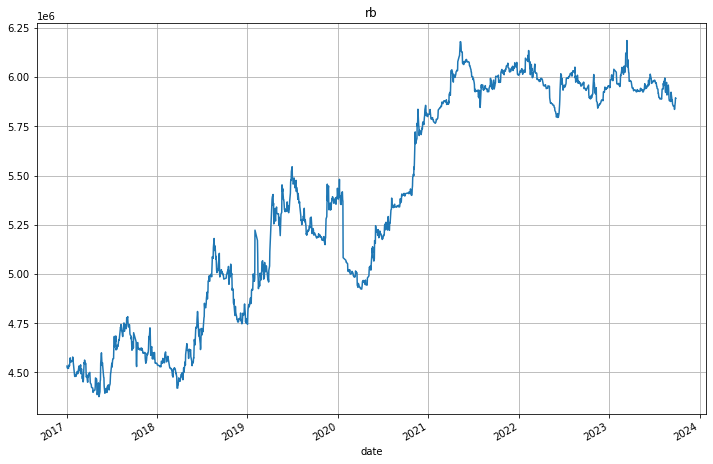

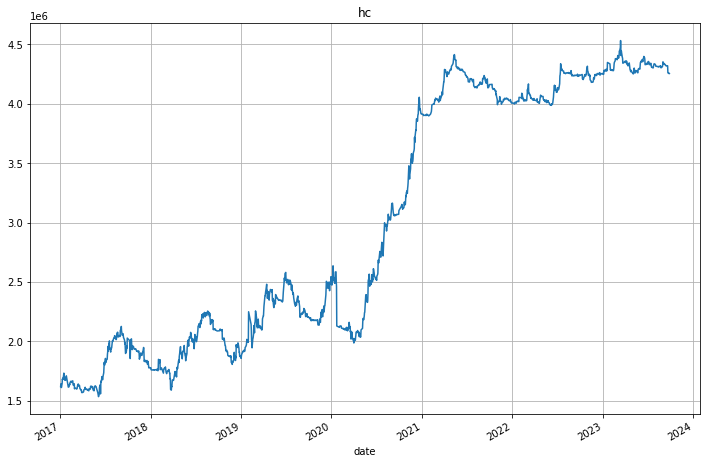

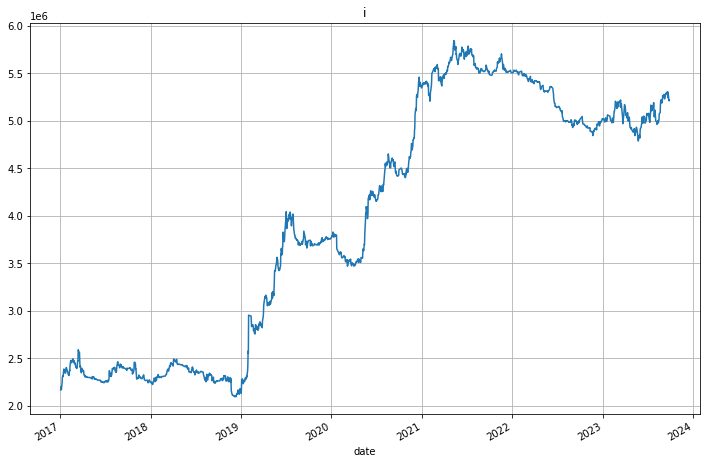

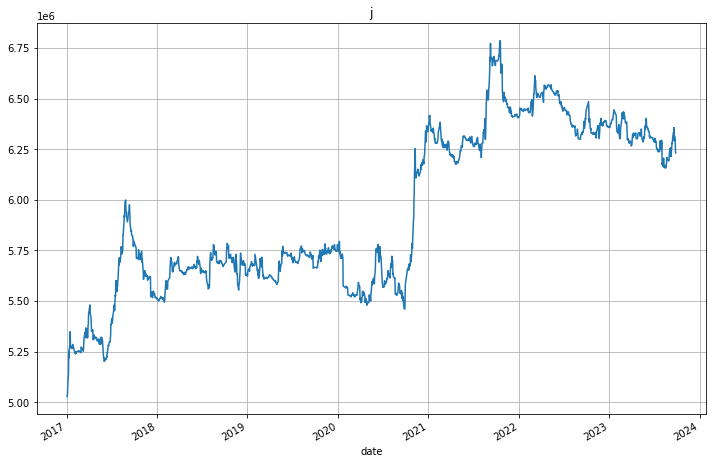

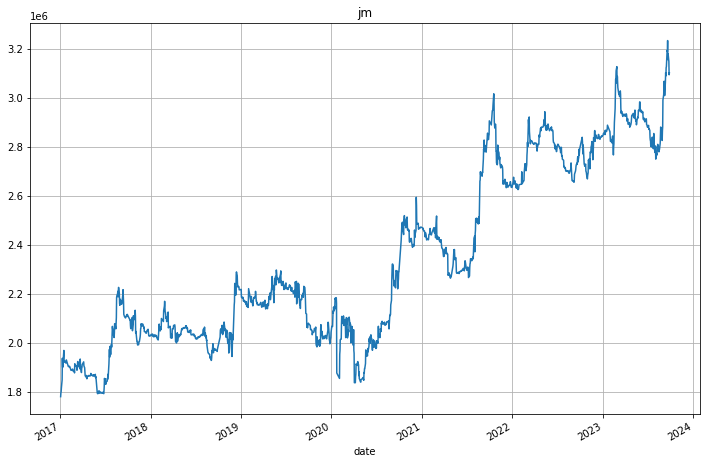

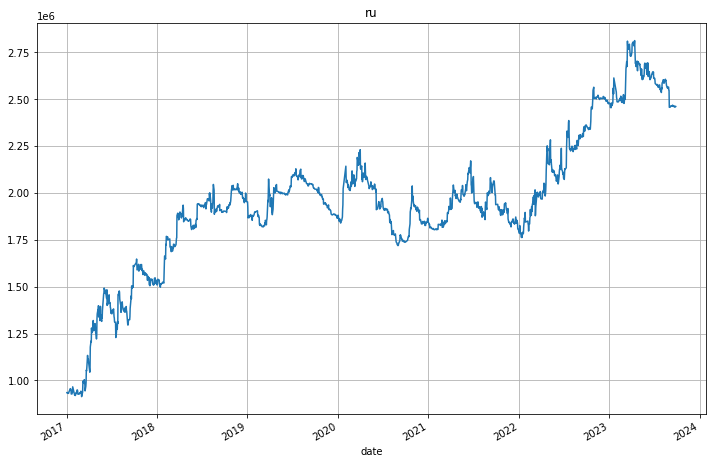

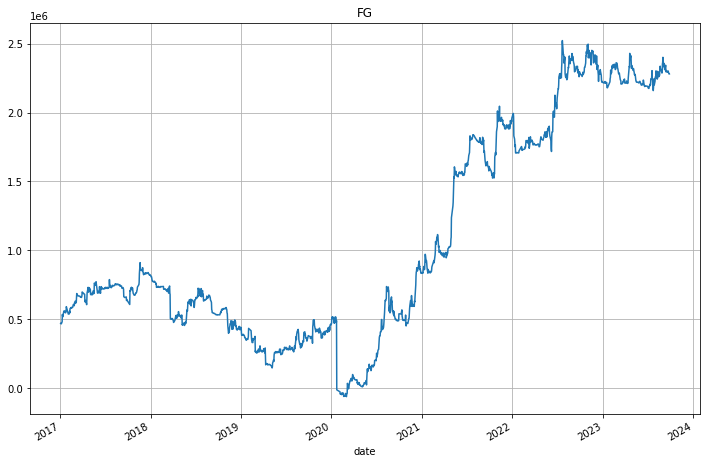

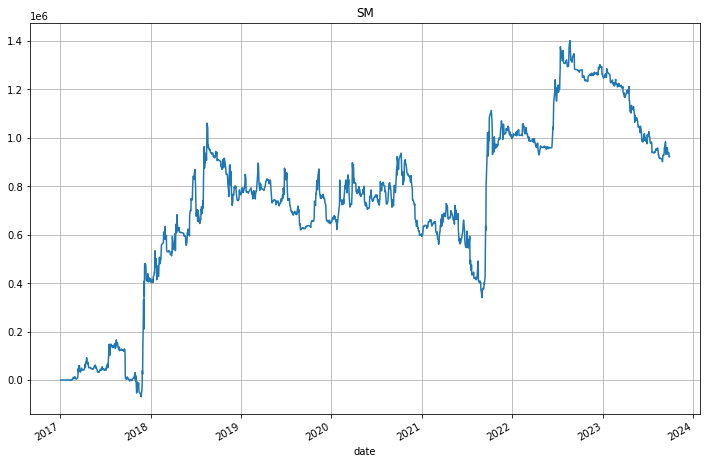

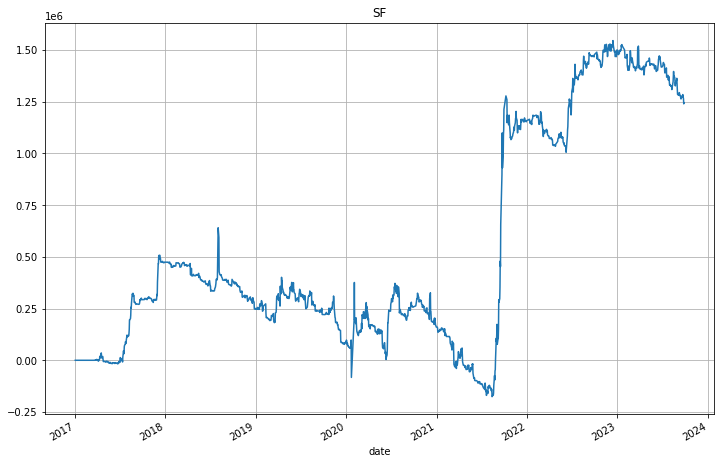

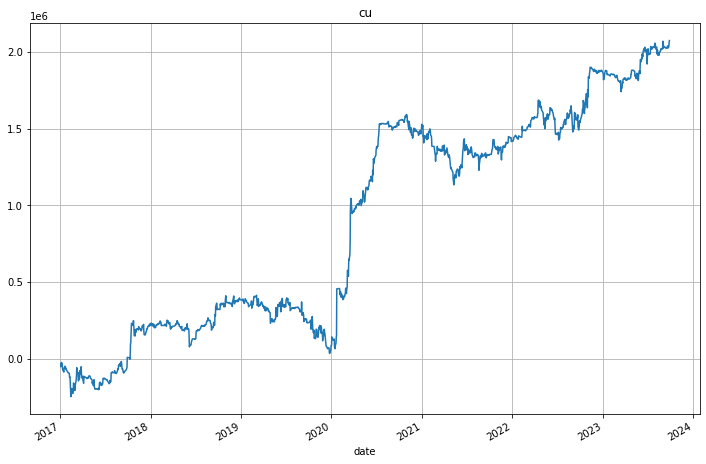

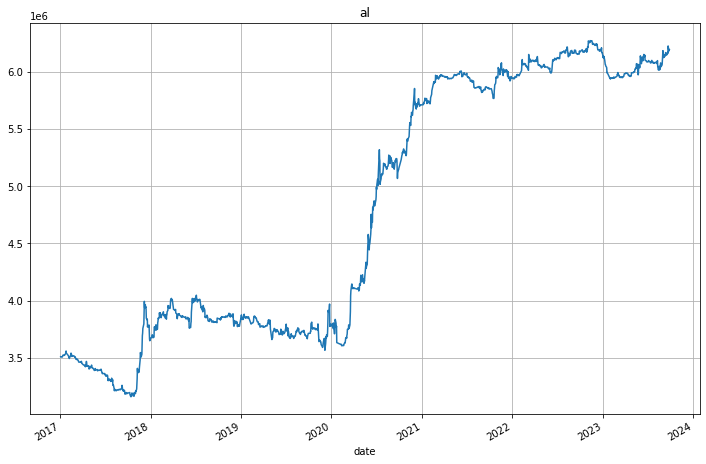

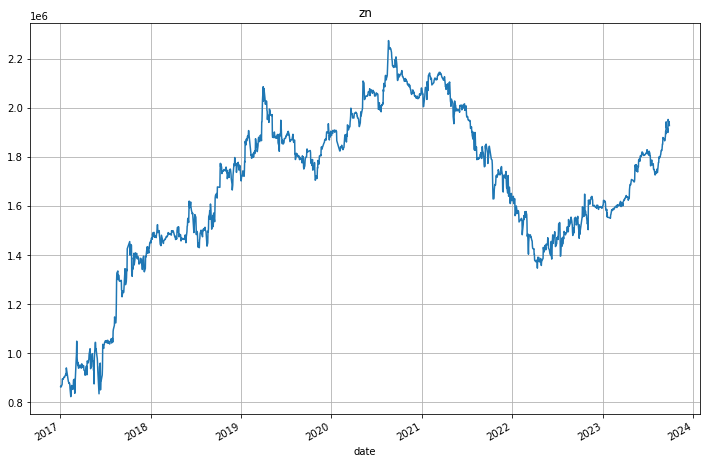

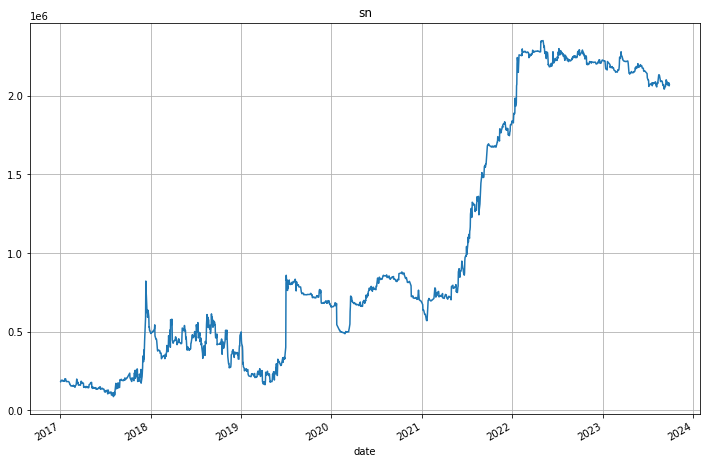

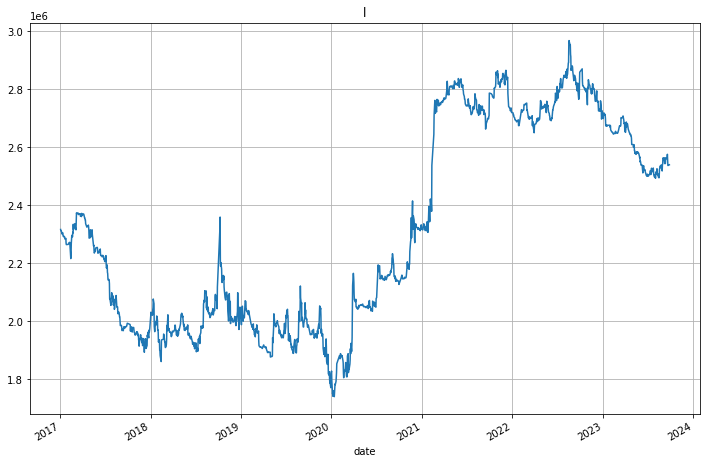

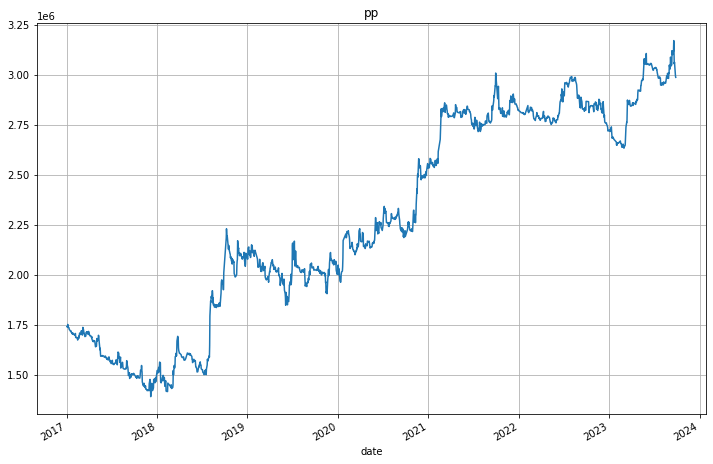

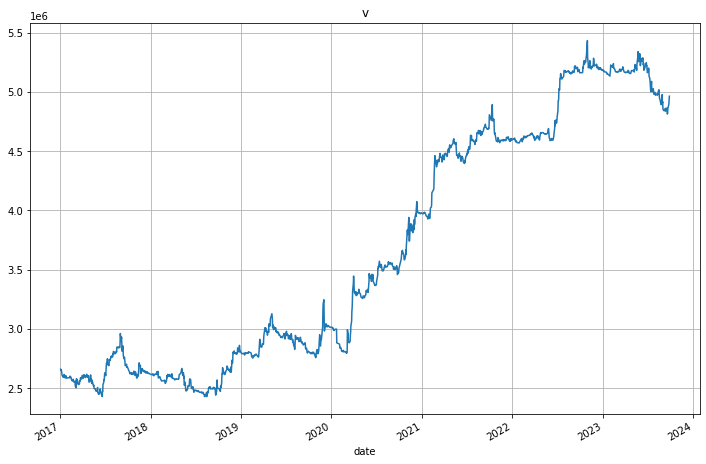

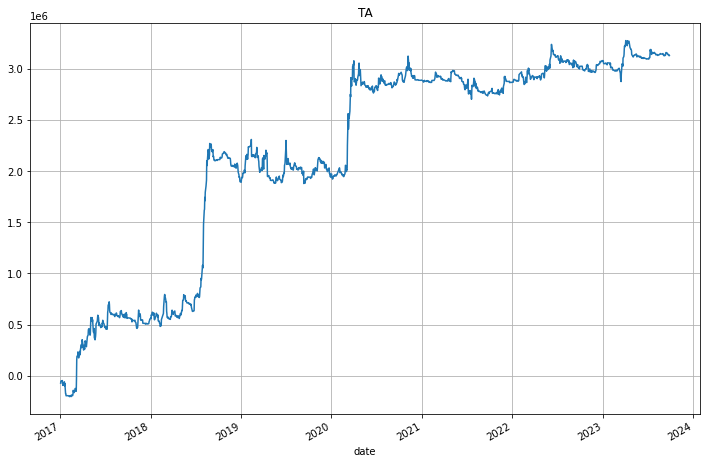

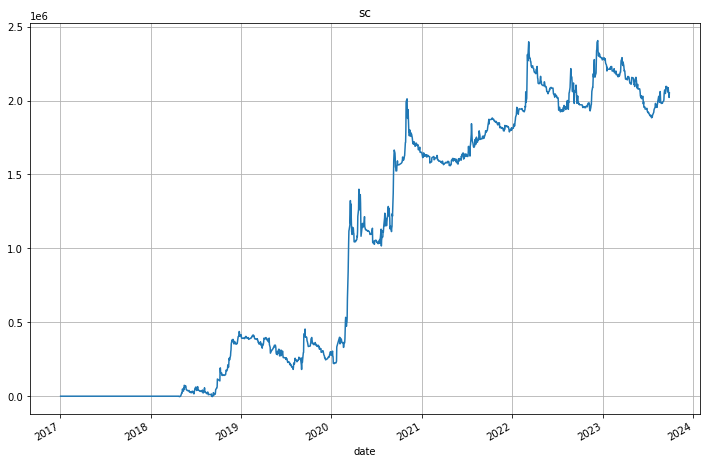

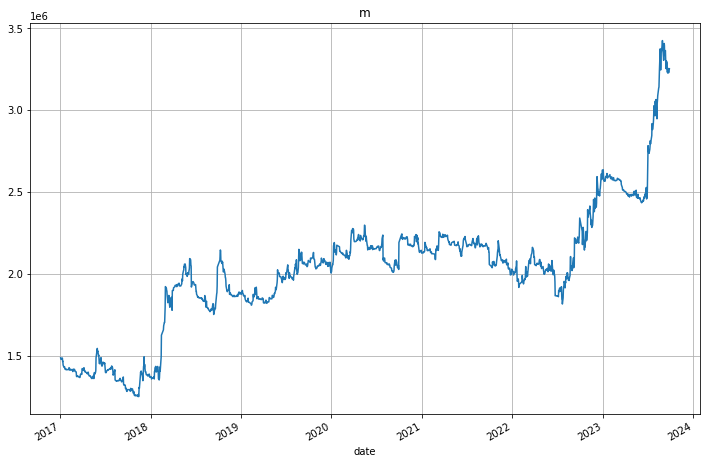

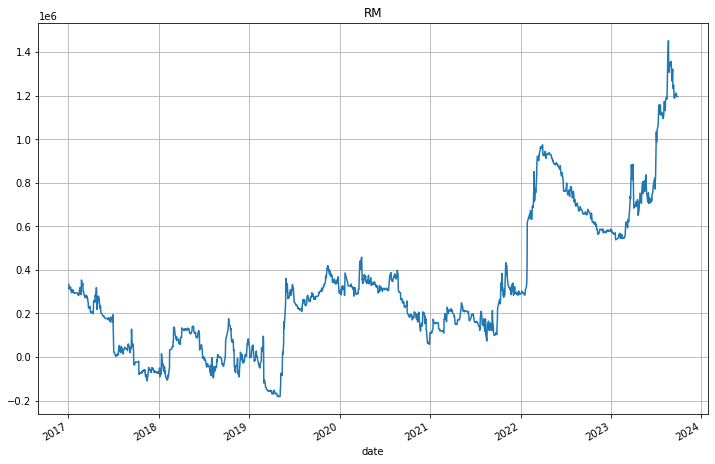

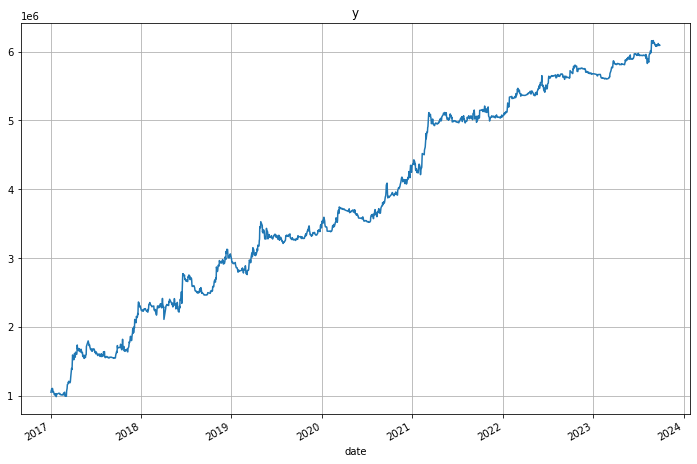

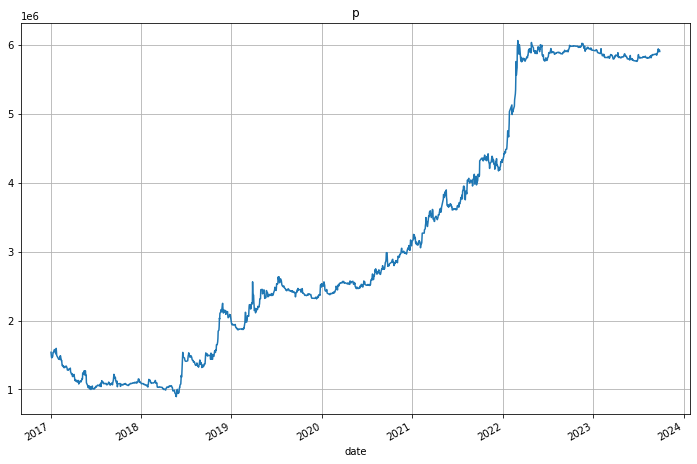

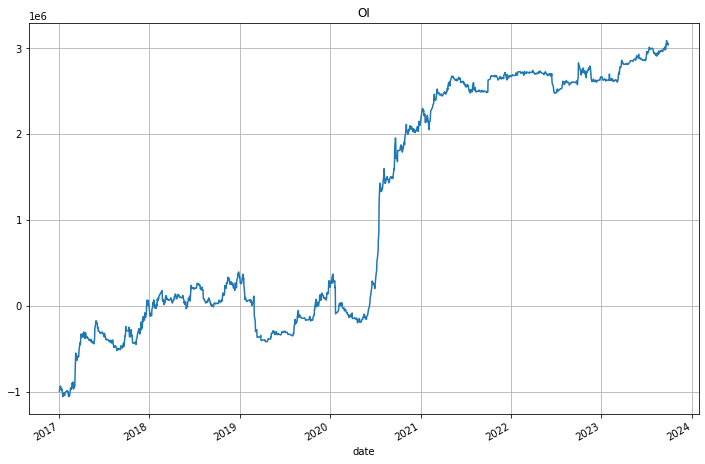

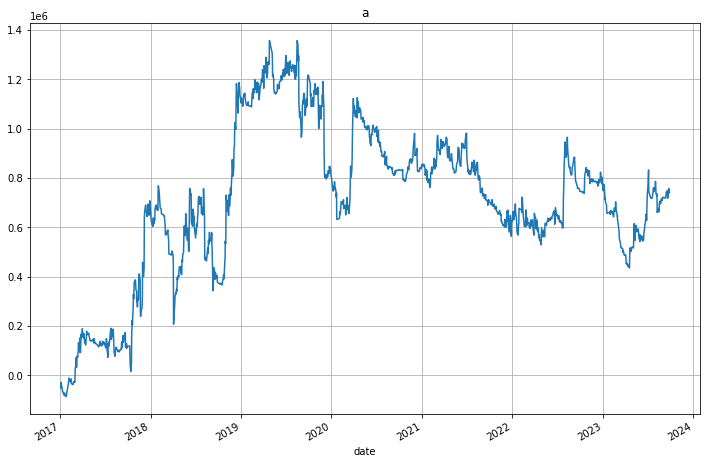

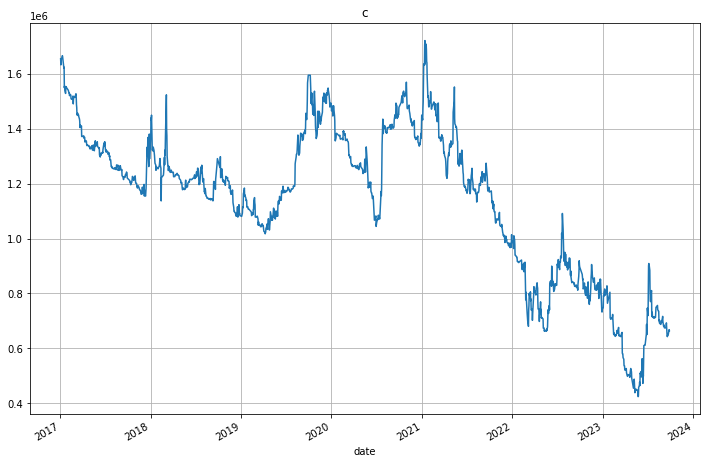

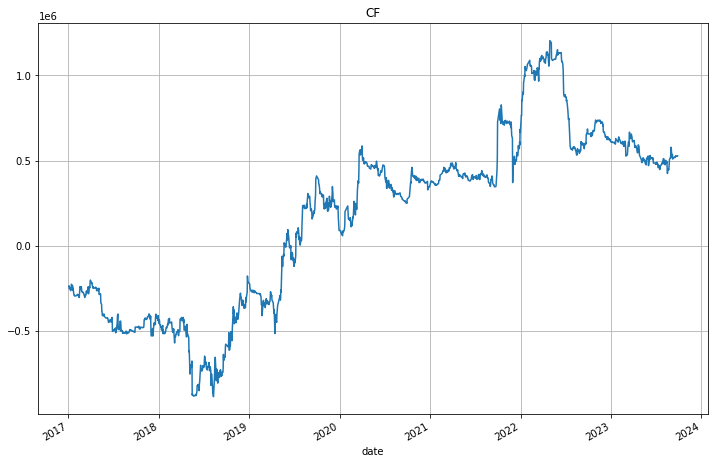

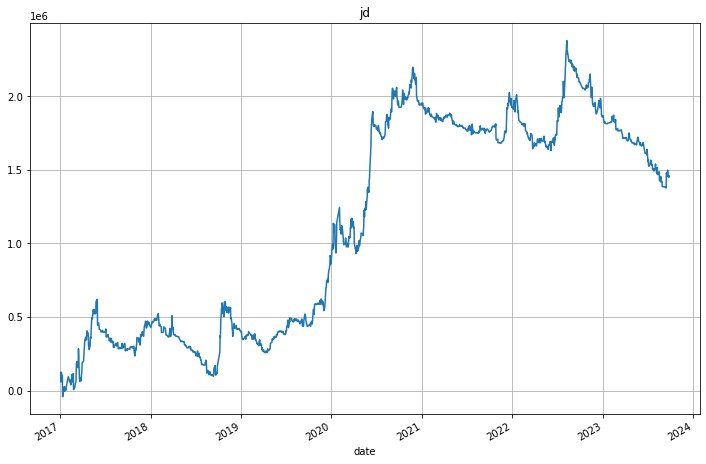

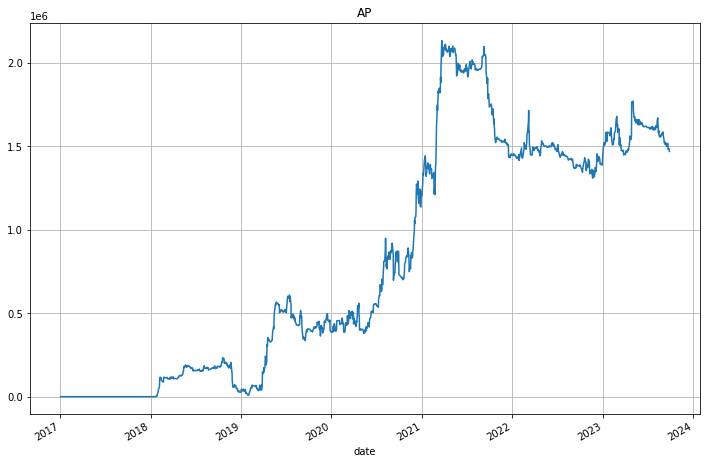

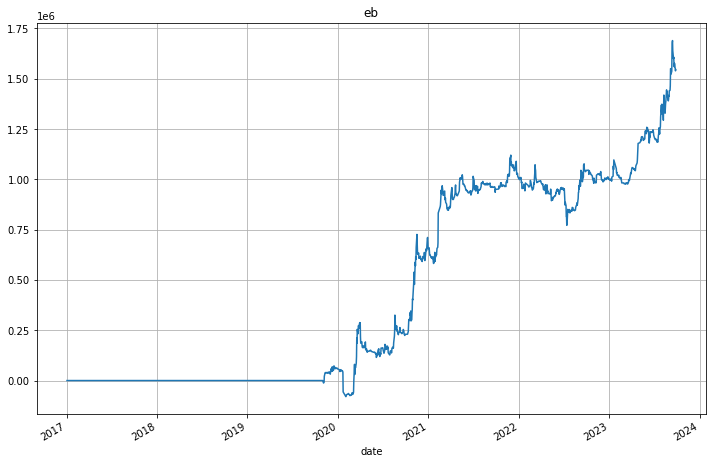

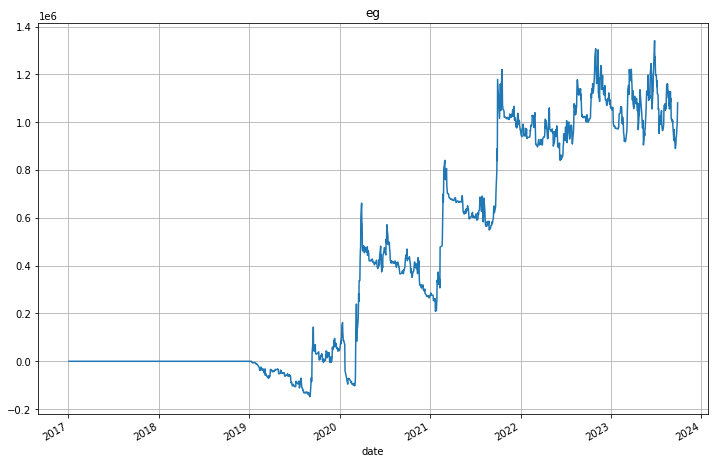

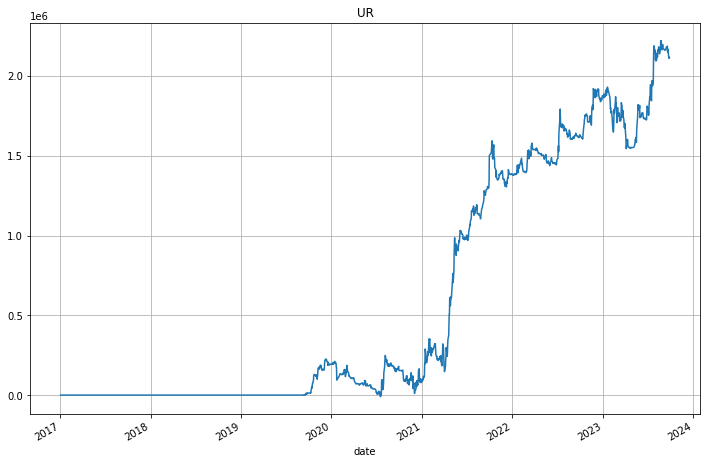

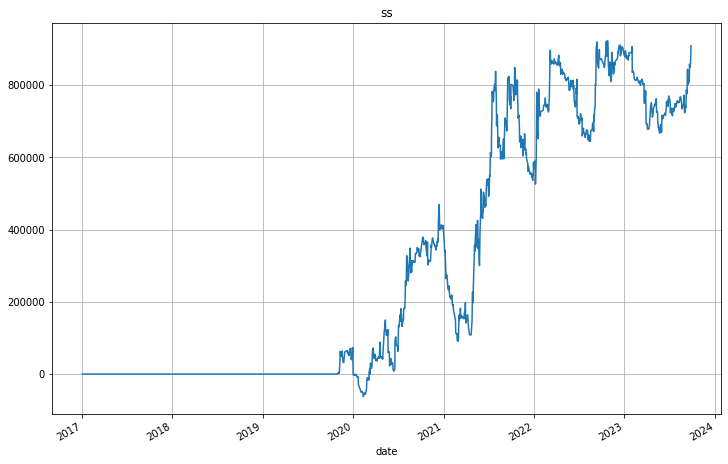

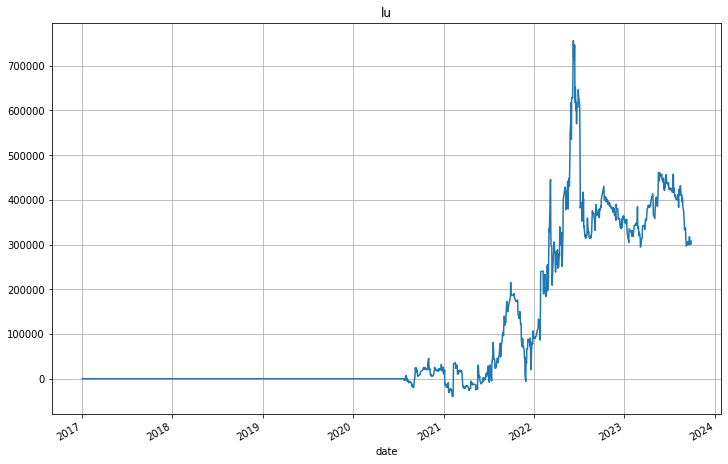

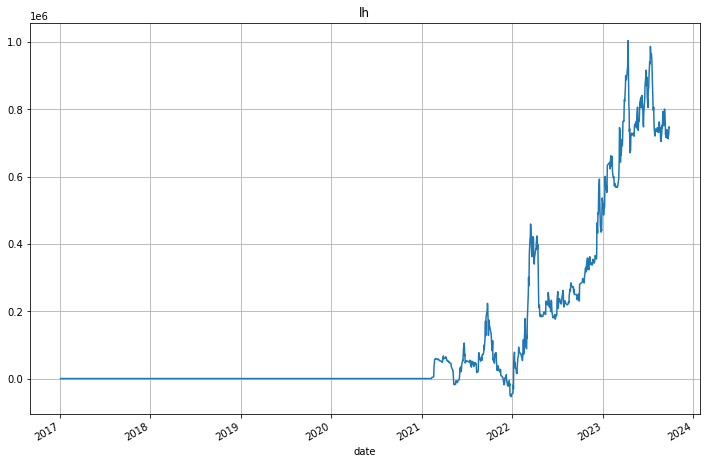

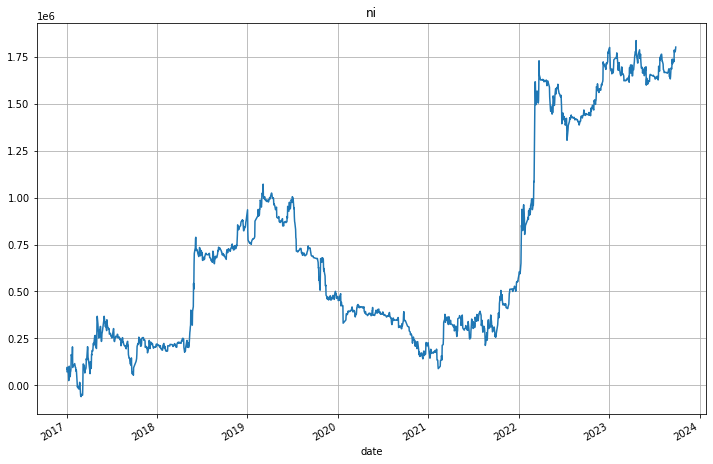

In [21]:
#pnl_stats = bt_empirics[run_key].calculate_pnl_stats(shift=0, tenors=pnl_tenors, perf_metrics=['sharpe', 'std', 'sortino', 'calmar'])

#pnl_stats['asset_sharpe_stats']

for asset in port_stats['asset_cumpnl'].columns:
    port_stats['asset_cumpnl'][asset]['2017-01-01':].plot(title=asset)
    plt.grid()
    plt.show()

In [22]:
pos_sum[product_list]

rb            hc             i             j  \
date                                                                 
2011-01-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
2023-09-21  1.377481e+04  2.392347e+06  2.191975e+06  2.046077e+06   
2023-09-22 -1.858401e+06 -4.341623e+05  1.960433e+06  1.680837e+06   
2023-09-25 -1.892953e+06  3.156081e+05  2.348700e+06  1.838406e+06   
2023-09-26 -2.420724e+06 -2.031739e+05  2.242619e+06  1.803373e+06   
2023-09-27 -3.249248e+06 -1.570339e+06  2.085044e+06  1.161707e+06   

                      jm             ru             FG             SM  \
date                                                                    
2011-01-04  0.000000e+00       0.000000       0.000000       0.000000   
2011-01-05  0.000000e+00       0.000000       0.000000       0.000000   
2011-01-06  0.000000e+00       0.000000       0.000000       0.000000   
2011-01-07  0.000000e+00       0.000000       0.000000       0.000000   
2011-01-10  0.000000e+00       0.000000       0.000000       0.000000   
...                  ...            ...            ...            ...   
2023-09-21  1.780823e+06 -164326.715156  375181.025693  927087.700496   
2023-09-22  1.616560e+06 -330296.881370  266930.251368  344719.751344   
2023-09-25  1.653510e+06 -242659.647425  672692.234620   53179.502243   
2023-09-26  1.581290e+06   82686.027634  547258.445977 -795930.702067   
2023-09-27  1.168946e+06 -274922.858163  472415.264263 -111253.942560   

                      SF            cu            al            zn  \
date                                                                 
2011-01-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
2023-09-21  4.060535e+05  2.857325e+05  2.773510e+06  1.036529e+06   
2023-09-22  7.603990e+05 -6.911753e+05  3.398829e+06  1.704322e+06   
2023-09-25  6.752753e+05 -2.232107e+06  4.830410e+06  2.291626e+06   
2023-09-26 -1.519187e+06 -2.787172e+06  2.799033e+06  1.551666e+06   
2023-09-27 -1.341257e+06 -4.364816e+06  2.286926e+06  1.127430e+06   

                      sn             l            pp             v  \
date                                                                 
2011-01-04  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
2023-09-21  4.147753e+05  1.652604e+06  4.667851e+06 -2.042569e+06   
2023-09-22  1.906797e+06  8.342994e+04  3.125510e+06 -2.508813e+06   
2023-09-25  5.849660e+05 -2.138222e+05  3.149050e+06 -2.785307e+06   
2023-09-26  1.754571e+06 -4.000006e+05  2.535884e+06 -3.042990e+06   
2023-09-27 -5.227407e+05 -1.947298e+05  2.033538e+06 -3.501750e+06   

                       TA            sc             m             RM  \
date                                                                   
2011-01-04       0.000000  0.000000e+00  0.000000e+00       0.000000   
2011-01-05       0.000000  0.000000e+00  0.000000e+00       0.000000   
2011-01-06       0.000000  0.000000e+00  0.000000e+

In [16]:
port_stats = bt_met.calculate_pnl_stats(shift=0, tenors=pnl_tenors)


In [13]:
ts1 = bt_empirics['hot_elite'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']
ts2 = bt_empirics['hot_test'].calculate_pnl_stats(shift=0, tenors=pnl_tenors)['portfolio_cumpnl']


# holding and std for strategy group

In [47]:
file_folder = "C:\\dev\\data\\data_cache\\"

#port_stats['portfolio_cumpnl'].to_csv(file_folder + "port_pnl_est.csv")

print(bt_met.holdings)

print(port_stats['portfolio_pnl'].resample('M').sum()[-60:])


product               rb            hc             i             j  \
2011-01-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-06  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-07  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-10  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-11  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
...                  ...           ...           ...           ...   
2023-06-21  1.056372e+07  1.102393e+07  7.798649e+06  6.895599e+06   
2023-06-26  1.076198e+07  1.072038e+07  7.717884e+06  6.237842e+06   
2023-06-27  1.027072e+07  9.973908e+06  7.389216e+06  5.534286e+06   
2023-06-28  8.728962e+06  8.415126e+06  6.655643e+06  4.384692e+06   
2023-06-29  1.092058e+07  1.047982e+07  8.281332e+06  5.790644e+06   

product               jm            FG            al             v  \
2011-01-05  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
2011-01-06  0.00000

In [70]:
tenors = ['1y', '2y', '3y', '5y', '7y', '9y', '11y']
data_list = []
run_key = 'hot_funda'
for scen_name, scen, pl_stat in zip(scen_names[run_key], scenarios, scen_stats[run_key]):
    weight = scen[2]
    data = [scen_name, weight] + [pl_stat['std'].loc[f'std_{ten}'] for ten in tenors] + [pl_stat['sharpe'].loc[f'sharpe_{ten}'] for ten in tenors]
    data_list.append(data)
    
data_df = pd.DataFrame(data_list, columns=['strat_name', 'weight'] + [f'std_{ten}' for ten in tenors] + [f'sharpe_{ten}' for ten in tenors])
data_df = data_df.set_index('strat_name')
data_df

weight        std_1y        std_2y  \
strat_name                                                              
funda-io_removal_lvl-1-1-1              1  10539.999058  10717.984193   
funda-io_removal_lyoy-1-1-1             1  24186.353353  24350.917398   
funda-io_millinv_lyoy-1-1-1             1  55376.479169  55130.179186   
funda-io_invdays_lyoy-1-1-1             1  67067.271042  67689.208981   
funda-io_invdays_lvl-1-1-1              1  49966.482892  53737.404184   
funda-strip_hsec_lvl_mid-1-1-1          1  49822.459691  48968.899697   
funda-steel_margin_lvl_fast-1-1-1       1  46054.633722  48314.889818   

                                         std_3y        std_5y        std_7y  \
strat_name                                                                    
funda-io_removal_lvl-1-1-1         10504.170124  11559.172702  11477.290082   
funda-io_removal_lyoy-1-1-1        24687.889723  24674.921993  24573.859764   
funda-io_millinv_lyoy-1-1-1        54983.694613  56898.547051  56677.049716   
funda-io_invdays_lyoy-1-1-1        65906.442655  66657.343945  65364.294012   
funda-io_invdays_lvl-1-1-1         55116.755618  56105.119597  55064.925208   
funda-strip_hsec_lvl_mid-1-1-1     50159.066045  48739.597643  47326.631632   
funda-steel_margin_lvl_fast-1-1-1  49783.749345  50718.400860  49833.437587   

                                         std_9y       std_11y  sharpe_1y  \
strat_name                                                                 
funda-io_removal_lvl-1-1-1         11309.145909  11309.145909   0.856589   
funda-io_removal_lyoy-1-1-1        24573.859764  24573.859764   0.337170   
funda-io_millinv_lyoy-1-1-1        56677.049716  56677.049716   2.250013   
funda-io_invdays_lyoy-1-1-1        66019.624528  66019.624528   1.785749   
funda-io_invdays_lvl-1-1-1         54424.587769  54003.351499   0.342828   
funda-strip_hsec_lvl_mid-1-1-1     49125.913492  46859.351201   1.175680   
funda-steel_margin_lvl_fast-1-1-1  53396.636491  53396.636491   0.278800   

                                   sharpe_2y  sharpe_3y  sharpe_5y  sharpe_7y  \
strat_name                                                                      
funda-io_removal_lvl-1-1-1          0.769049   1.004261   1.145732   1.325949   
funda-io_removal_lyoy-1-1-1         1.330662   0.995041   0.962112   1.123809   
funda-io_millinv_lyoy-1-1-1         0.580467   1.359110   1.334027   1.587012   
funda-io_invdays_lyoy-1-1-1         0.503932   1.840426   1.680487   1.595403   
funda-io_invdays_lvl-1-1-1          1.236448   2.407103   1.493373   1.543761   
funda-strip_hsec_lvl_mid-1-1-1      1.198828   1.856597   1.489054   1.476154   
funda-steel_margin_lvl_fast-1-1-1   0.437692   1.376213   1.444439   1.355377   

                                   sharpe_9y  sharpe_11y  
strat_name                                                
funda-io_removal_lvl-1-1-1          1.342996    1.342996  
funda-io_removal_lyoy-1-1-1         1.123809    1.123809  
funda-io_millinv_lyoy-1-1-1         1.587012    1.587012  
funda-io_invdays_lyoy-1-1-1         1.441887    1.441887  
funda-io_invdays_lvl-1-1-1          1.455570    1.440225  
funda-strip_hsec_lvl_mid-1-1-1      1.619412    1.610451  
funda-steel_margin_lvl_fast-1-1-1   1.386257    1.386257

In [22]:
data_df.to_excel("port_perf_check.xlsx")

# asset level cum pnl

product           rb        hc         i         j        jm        ru  \
sharpe      0.323876  0.809957  0.724711  0.475860  0.428585  0.562446   
sharpe_6m  -0.890350  0.134250  1.753153       NaN       NaN -0.504611   
sharpe_1y  -0.267060  1.519788  0.586632 -1.891429       NaN  0.957608   
sharpe_2y  -0.190253  1.125374  0.300596  0.216499  0.535823  0.590105   
sharpe_3y   0.494870  1.888858  1.184239 -0.237671  0.420748  0.337683   
sharpe_4y   0.449147  1.456568  0.949912  0.112318  0.035228  0.506445   
sharpe_5y   0.199359  1.256697  0.883913  0.001861  0.174178  0.603708   
sharpe_6y   0.094969  1.078674  0.749858  0.471455  0.037831  0.671506   
sharpe_7y   0.088793  0.990913  0.828085  0.557333  0.526836  0.562704   
sharpe_8y   0.314868  0.856111  0.783751  0.652089  0.409960  0.513486   
sharpe_9y   0.331092  0.809957  0.738972  0.578575  0.449763  0.534781   
sharpe_10y  0.311325  0.809957  0.724711  0.650699  0.428585  0.591412   
sharpe_11y  0.323876  0.809957  0.7247

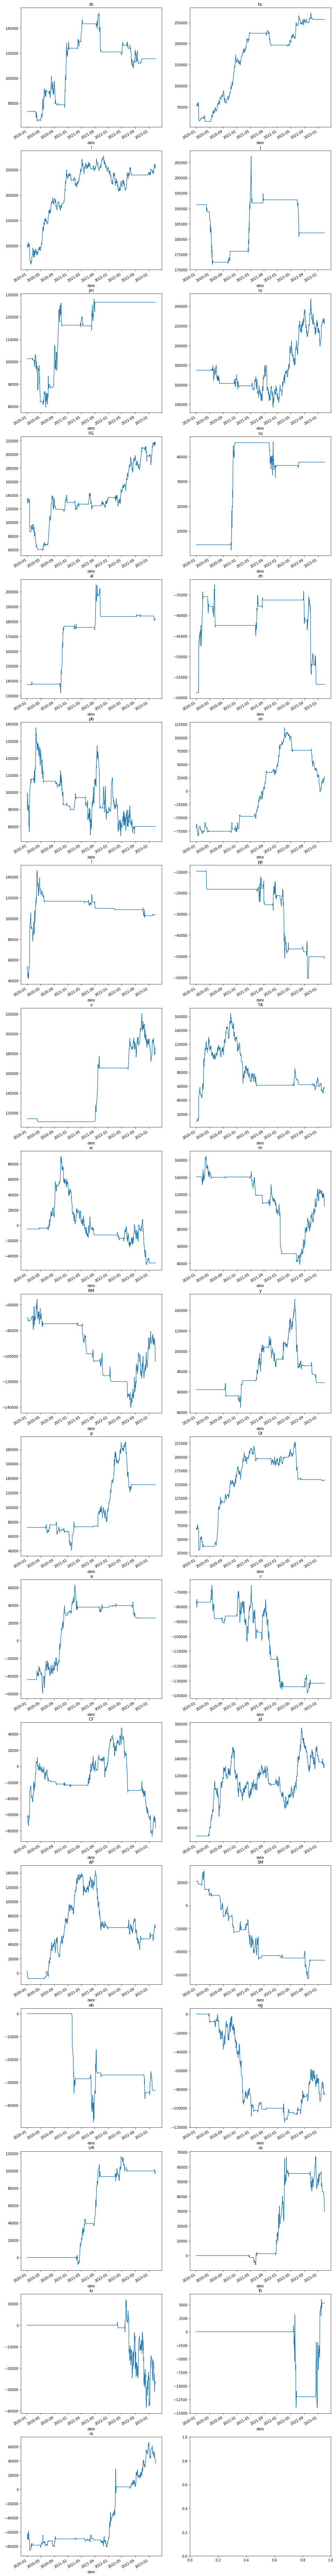

In [15]:
#plot_stats = scen_stats[0]
plot_stats = pnl_stats
asset_pnl = plot_stats['asset_cumpnl']
asset_stats = plot_stats['asset_sharpe_stats']
plot_start = pd.to_datetime('2020-01-01')

rows = math.ceil(len(product_list)/2)
fig, ax = plt.subplots(rows, 2, figsize=(16, 150))

for i, col in enumerate(asset_pnl.columns):
    row_id = i//2
    col_id = i % 2
    asset_pnl[col][plot_start:].plot(ax = ax[row_id, col_id], title = col)

print(asset_stats[product_list])
    

# smoothed pnl and lagged pnl

smoothed PNL
                  1         5         10        20        30        60  \
sharpe     0.175127 -0.028105 -0.098967 -0.166326 -0.197475 -0.201858   
sharpe_fh -0.644267 -0.688182 -0.705753 -0.724333 -0.725929 -0.688596   
sharpe_sh  1.757540  1.379782  1.254718  1.117915  1.025846  0.890852   

                 75        80  
sharpe    -0.185417 -0.178971  
sharpe_fh -0.665222 -0.657703  
sharpe_sh  0.858847  0.850731  


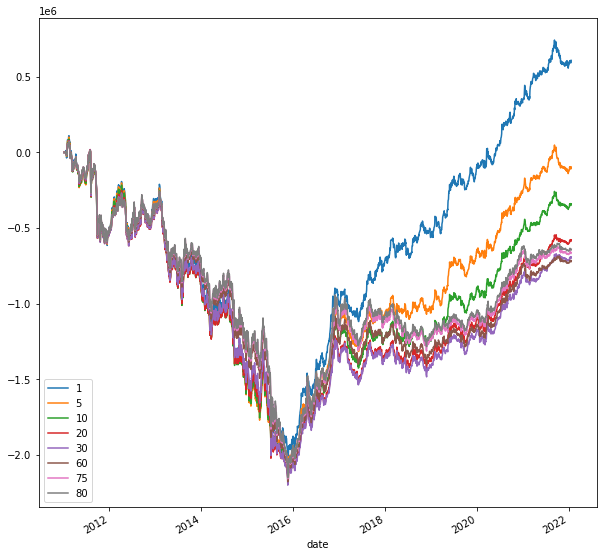

lagged PNL
                  1         5         10        20        30        60  \
sharpe     0.151961 -0.096850 -0.112085 -0.323440 -0.037762 -0.189401   
sharpe_fh -0.621991 -0.667313 -0.737889 -0.746321 -0.664814 -0.681529   
sharpe_sh  1.562776  0.929591  1.030327  0.397362  1.089161  0.661962   

                 75        80  
sharpe    -0.321416 -0.299983  
sharpe_fh -0.670788 -0.611414  
sharpe_sh  0.313514  0.270256  


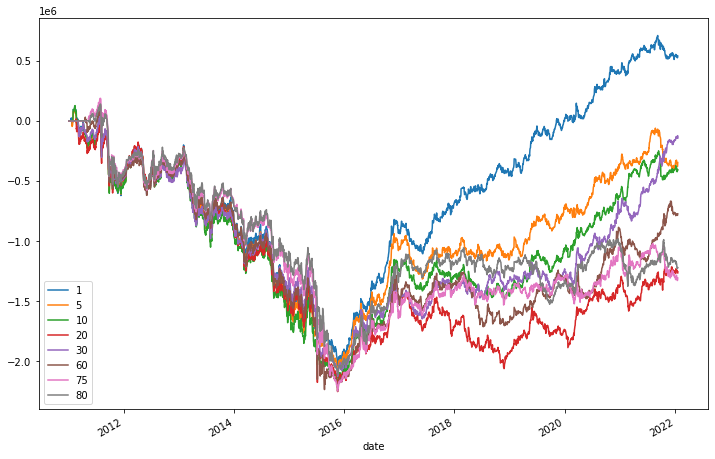

In [16]:

bt_metrics = scen_metrics[2]
smoothed = bt_metrics.smoothed_pnl(smooth_hls=[1, 5, 10, 20, 30, 60, 75, 80])
smoothed['cumpnl'].plot(figsize=(10,10))
print('smoothed PNL\n', smoothed['sharpe'])
plt.show()

lagged = bt_metrics.lagged_pnl(lags=[1, 5, 10, 20, 30, 60, 75, 80])
lagged['cumpnl'].plot()
print('lagged PNL\n', lagged['sharpe'])
plt.show()

# scenario PNL and correlations

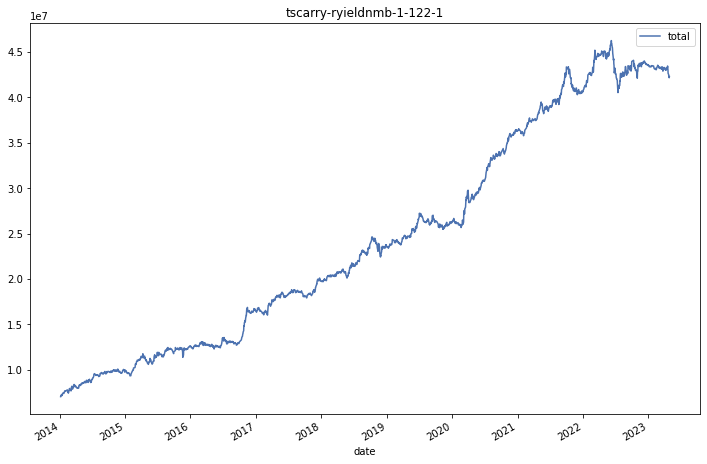

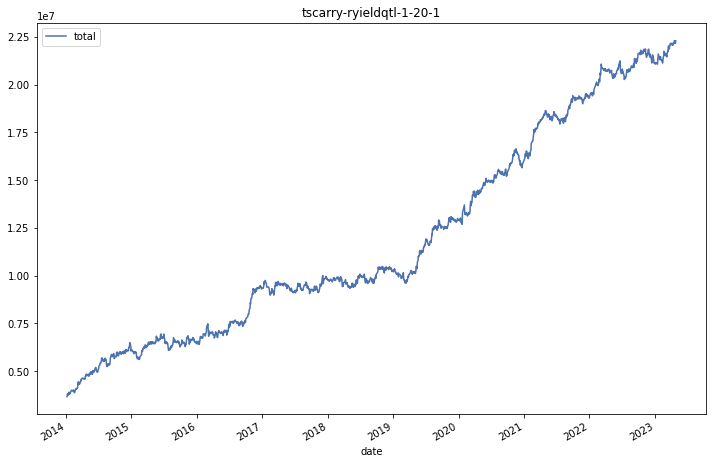

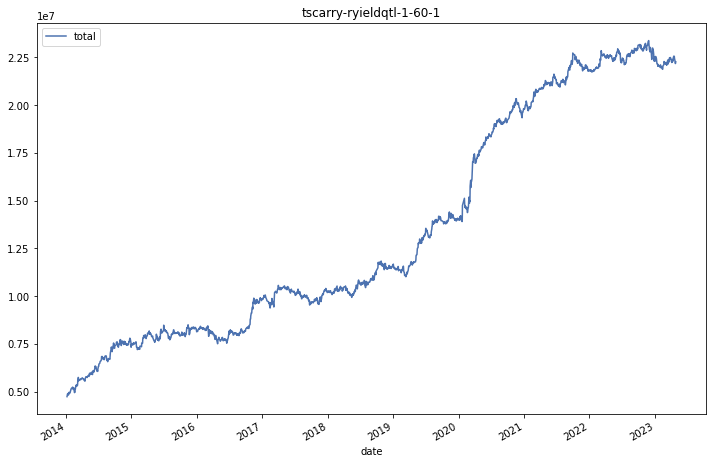

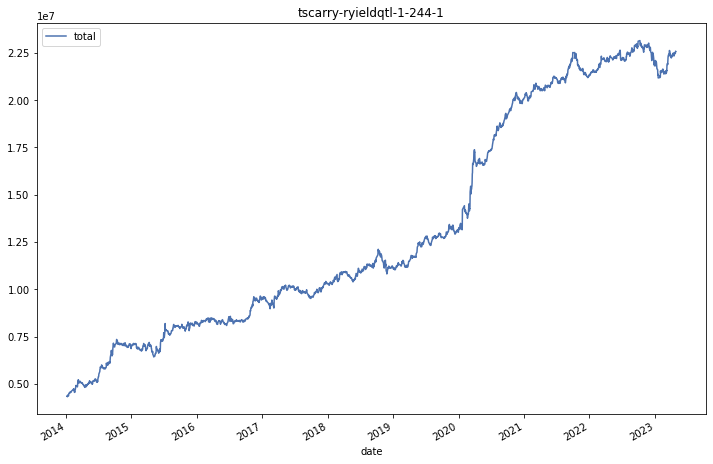

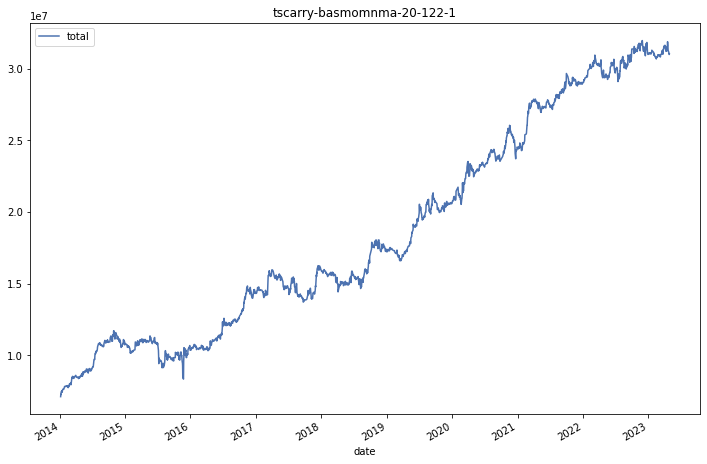

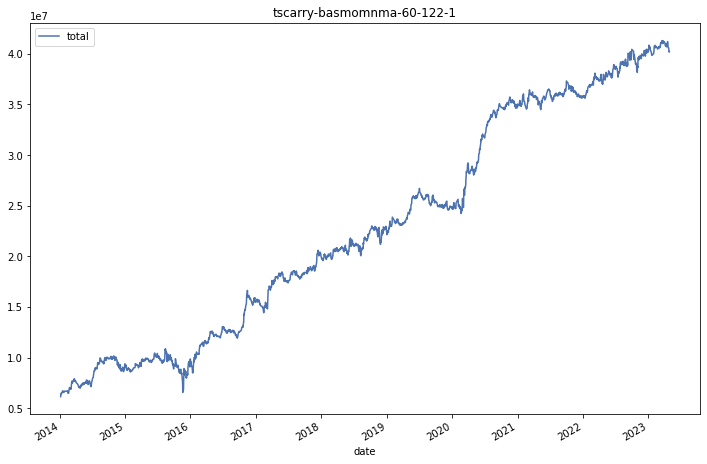

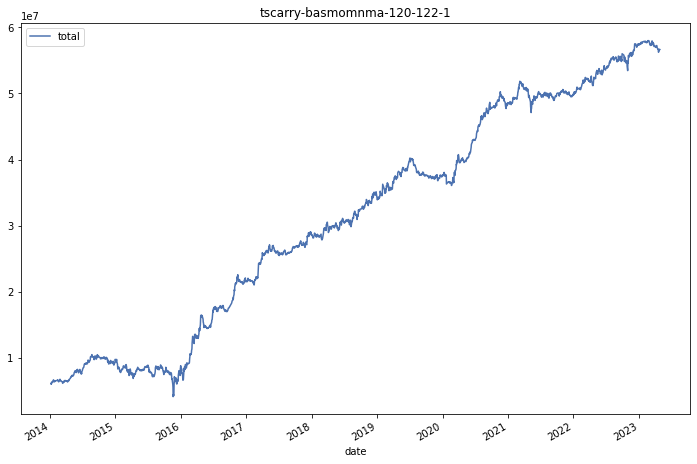

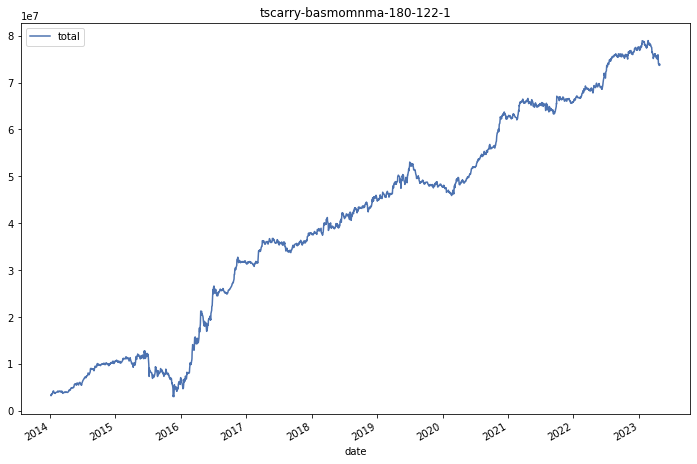

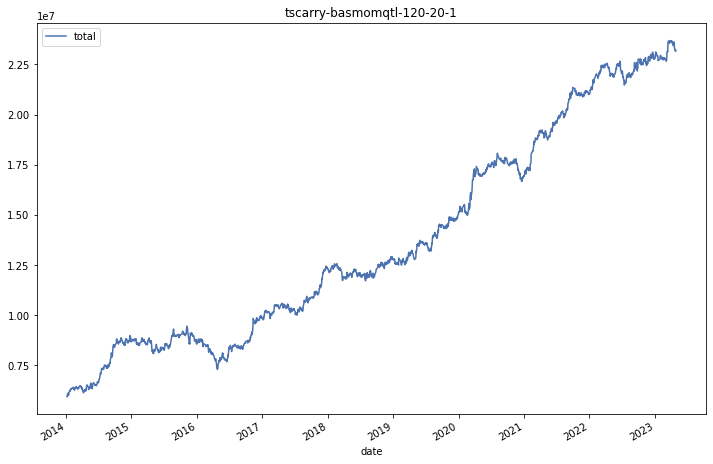

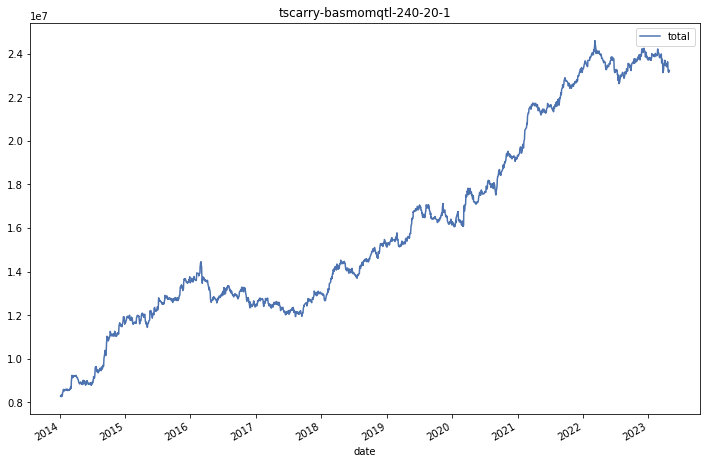

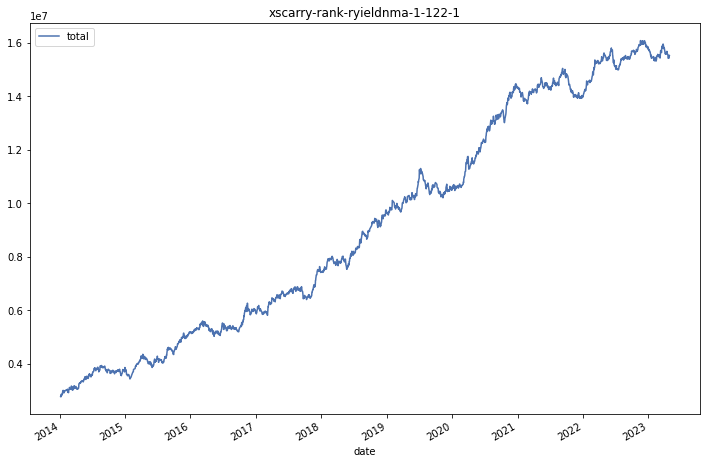

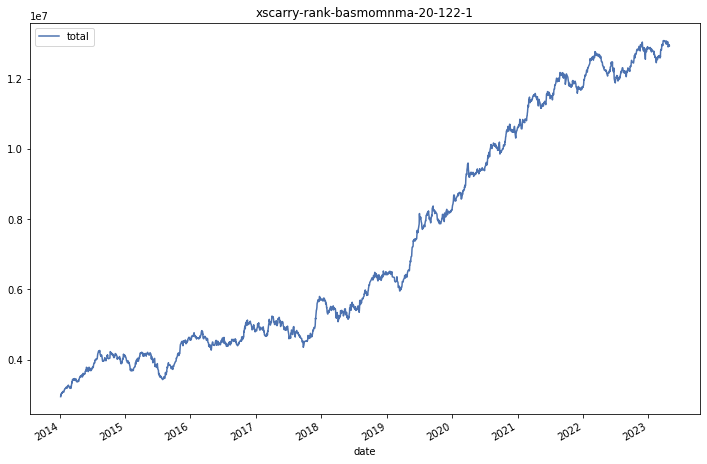

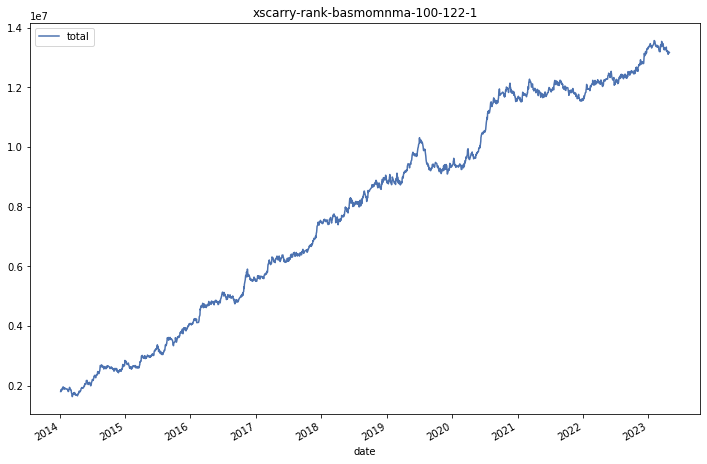

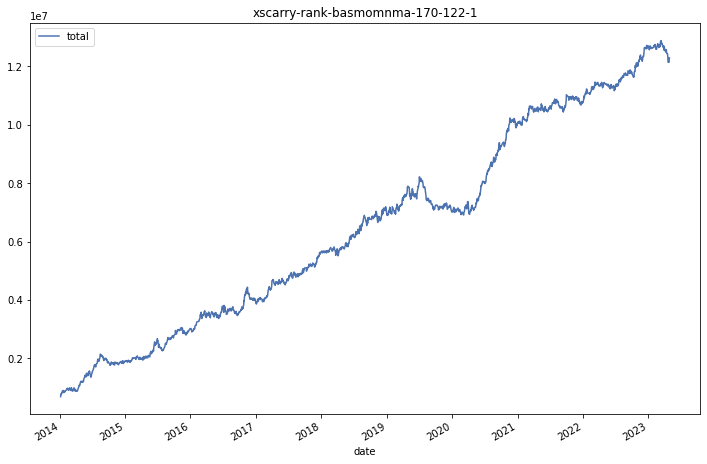

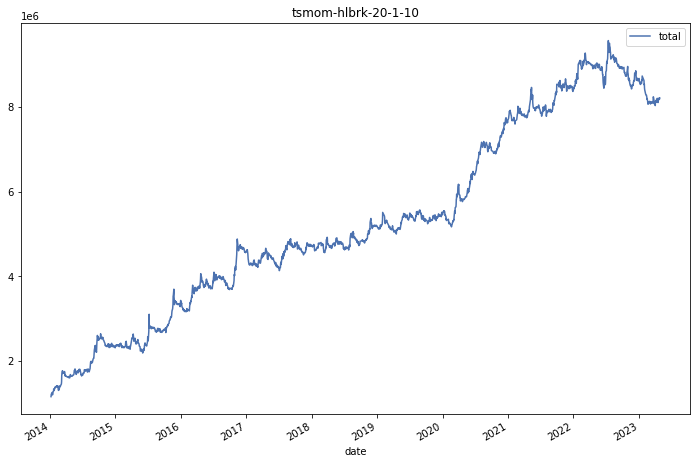

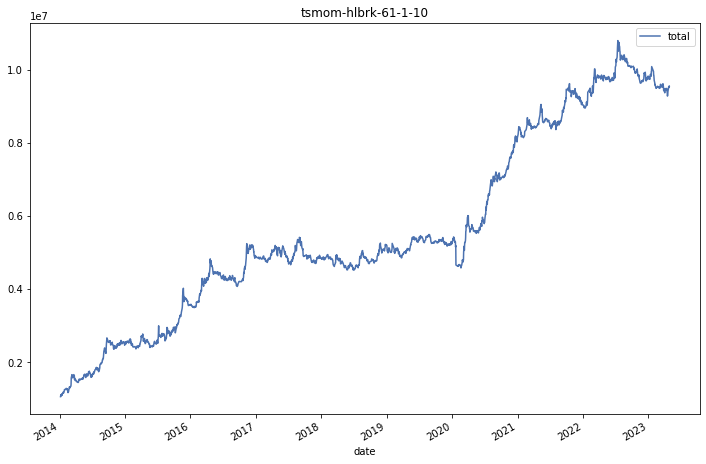

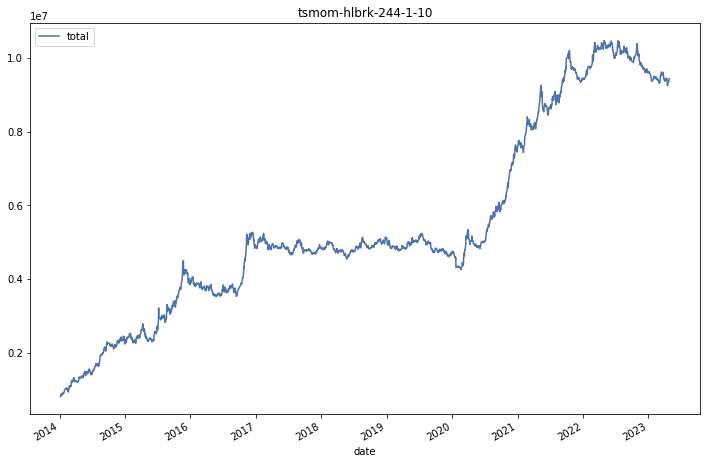

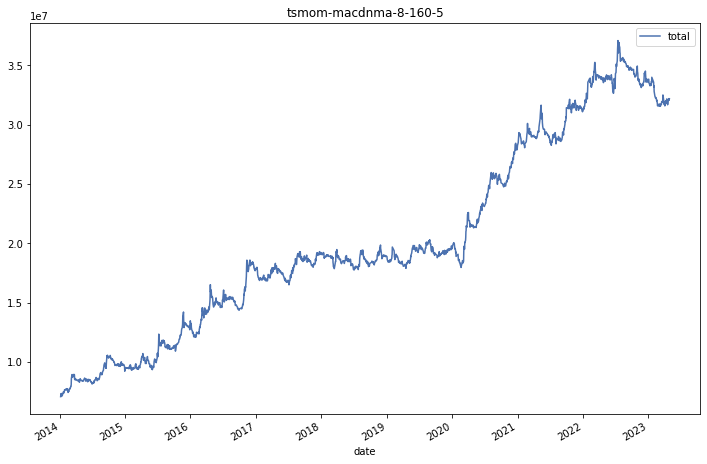

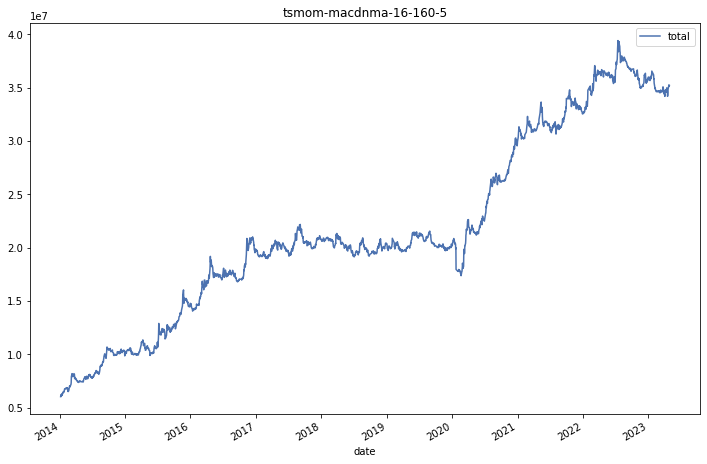

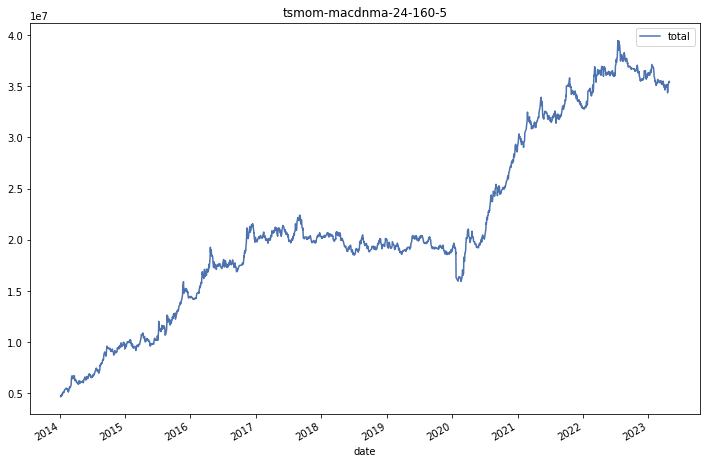

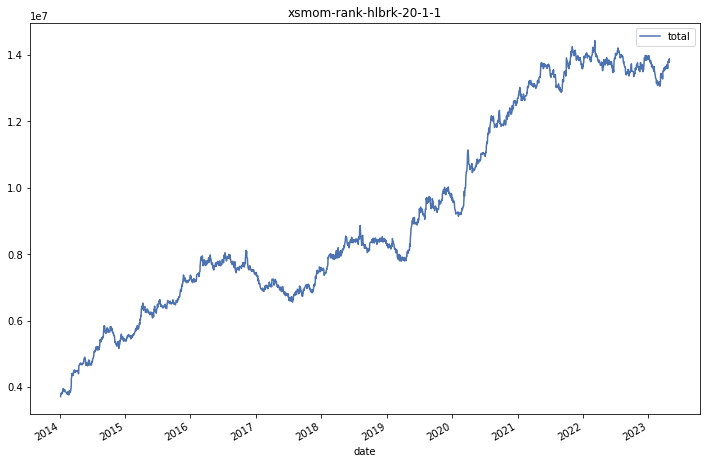

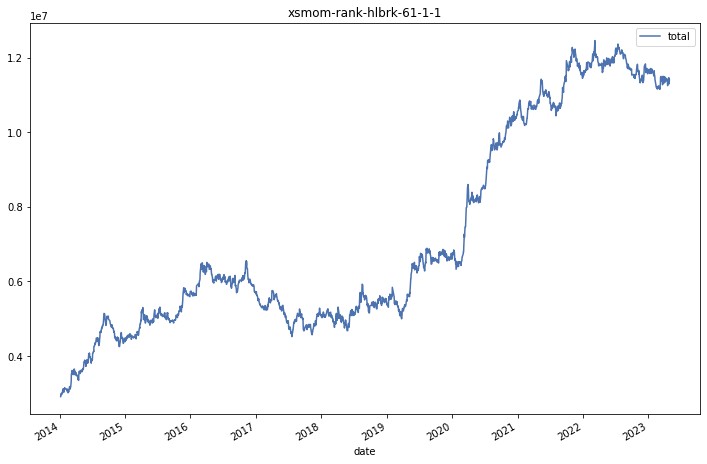

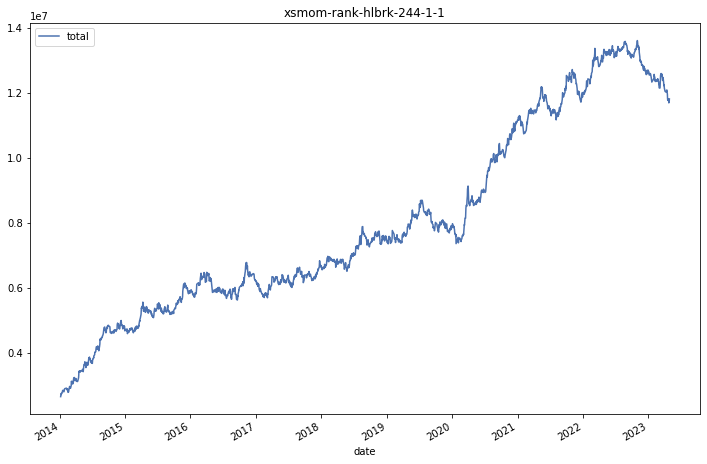

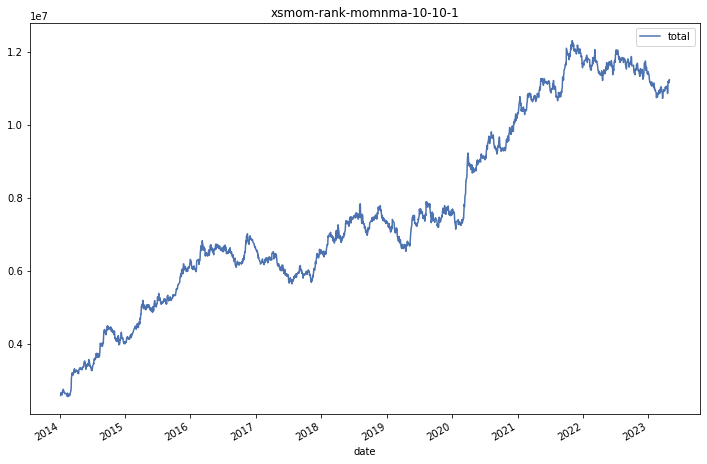

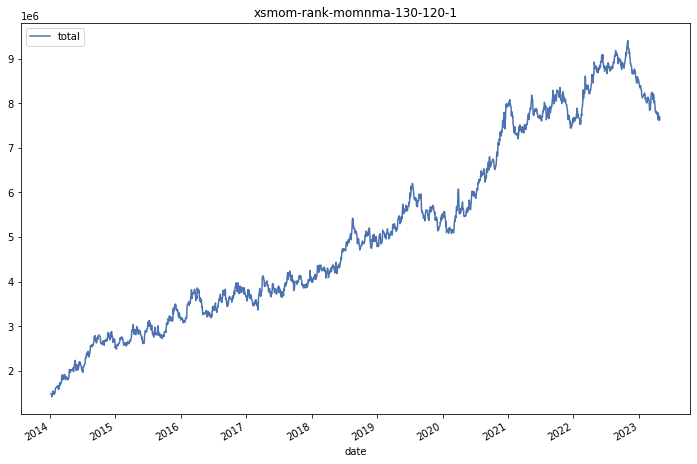

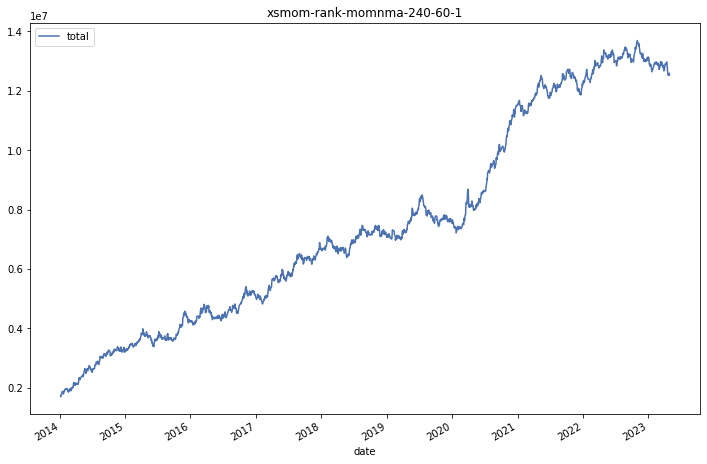

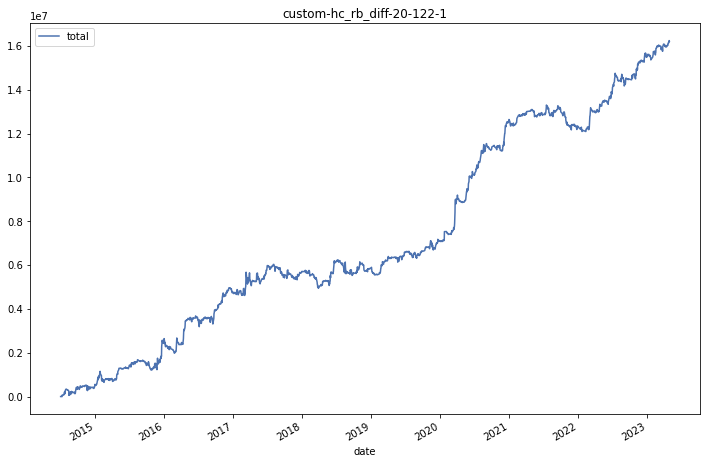

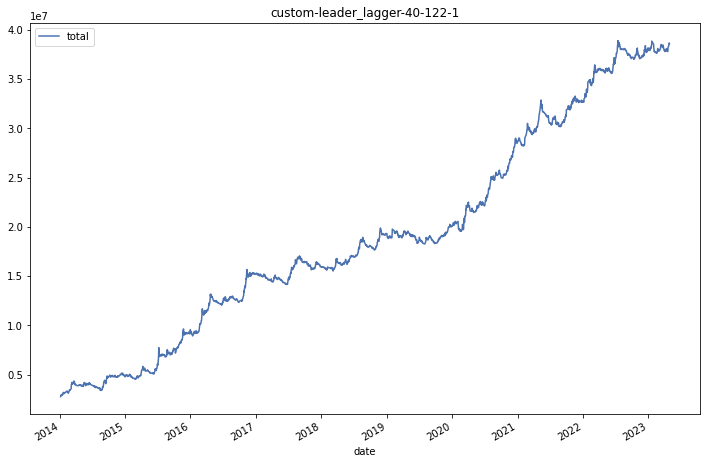

In [55]:
scen_start = pd.to_datetime('2014-01-01')
df_list = []
hot_key = 'hot_test'
for scen_name, scen_stat in zip(scen_names[hot_key], scen_stats[hot_key]):
    scen_stat['portfolio_cumpnl'][scen_start:].plot(title=scen_name)
    plt.show()
    ts = scen_stat['portfolio_pnl'][scen_start:]
    ts.name = scen_name
    df_list.append(ts)
dpnl_df = pd.concat(df_list, axis=1, join='outer').fillna(0)
dpnl_df.columns = scen_names[hot_key]
scen_corr = dpnl_df.corr()

# print(scen_corr)
scen_corr.to_csv(file_folder + "port_corr.csv")

# some test for backtest code

In [ ]:
input_args = run_args
product_list = input_args['product_list']
vol_win = input_args['std_win']
total_risk = input_args.get('total_risk', 5000000.0)
shift_mode = input_args.get('shift_mode', 1)
asset_scaling = input_args.get('asset_scaling', False)
exec_mode = input_args.get('exec_mode', 'open')
signal_df = generate_signal(df, input_args)

start_date = input_args.get('start_date', None)
end_date = input_args.get('end_date', None)

if start_date:
    signal_df = signal_df[signal_df.index >= pd.to_datetime(start_date)]
if end_date:
    signal_df = signal_df[signal_df.index <= pd.to_datetime(end_date)]

if shift_mode == 1:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='atr')
elif shift_mode == 2:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='lret')
else:
    vol_df = get_asset_vols(df, product_list, vol_win=vol_win, vol_type='close')


In [ ]:
holding = generate_holding_from_signal(signal_df, vol_df,
                                       risk_scaling=total_risk,
                                       asset_scaling=asset_scaling)
holding

In [ ]:
mpl.rcParams['figure.figsize'] = (8, 6)

# batch run backtest for multiple factors

In [ ]:
from bktest.backtest_grid_search import *

In [ ]:
df, error_list = load_hist_data(
    start_date=datetime.date(2010,1,1),
    end_date=datetime.date(2022,1,20),
    sim_markets=commod_all_mkts,
    freq='d'
)

if len(error_list) > 0:
    print(error_list)
print(df.tail(10))

In [11]:
start_d = datetime.date(2012,1,1)
end_d = datetime.date(2020,1,1)
product_list = ['rb', 'hc', 'i', 'j', 'jm', 'ru', 'FG', 'cu', 'al', 'zn', 'pb', 'sn', \
                'l', 'pp', 'v', 'TA', 'sc', 'm', 'RM', 'y', 'p', 'OI', 'a', 'c', 'CF', 'jd', \
                'AP', 'SM', 'eb', 'eg', 'UR', 'ss', 'lu', 'lh', 'ni',]

sim_group = [
    ('xscarry-rank', 'basmomema'), ('xscarry-rank_cutoff', 'basmomema'), ('xscarry-demedian', 'basmomema'),
    ('xscarry-rank', 'basmomqtl'), ('xscarry-rank_cutoff', 'basmomqtl'), ('xscarry-demedian', 'basmomqtl'),
]

index_list = range(10, 260, 10)
column_list = [10, 20, 40, 61, 80, 100, 122, 244]

bt_metric_dict = {}
pnl_stats_dict = {}
for sim_type, signal_name in sim_group:
    print(f"processing {sim_type} - {signal_name}")
    metric_dict, stat_dict = run_grid_btest(df, start_d, end_d, 
                                            sim_type, signal_name,
                                            index_list=index_list,
                                            column_list=column_list,
                                            product_list=product_list,
                                            pnl_tenors=True,
                                            exp_mean=False)
    bt_metric_dict[(sim_type, signal_name)] = metric_dict
    pnl_stats_dict[(sim_type, signal_name)] = stat_dict


processing xscarry-rank - basmomema
sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   1.614742  1.277921  1.149956  1.163646  1.306326  1.453083  1.396669   
20   1.569257  1.258853  1.122001  1.052935  1.220969  1.373404  1.471871   
40   1.512389  1.172369  1.114697  1.224178  1.415782  1.588075  1.622037   
61   1.416166  1.267703  1.275787  1.443834  1.570414  1.649171  1.782928   
80   1.510609  1.444942  1.441870  1.580338  1.649718  1.781360  1.666051   
100  1.618194  1.585641  1.606040  1.631402  1.706475  1.831097  1.722611   
122  1.679263  1.672687  1.633591  1.648201  1.732921  1.685257  1.688770   
244  1.930602  1.721691  1.578035  1.583048  1.622187  1.587168  1.406779   

                                                                           \
X         80        90        1

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.961644  0.850101  0.542298  0.564878  0.907803  1.176584  1.080917   
20   0.997791  0.821020  0.784525  0.680190  0.859258  0.873404  0.975884   
40   1.053649  0.718902  0.772178  0.606393  0.844922  0.904332  1.089073   
61   0.877748  0.814401  0.766541  0.745674  1.116072  1.053328  1.345649   
80   0.904226  0.611450  0.831292  1.050503  1.070957  1.328911  1.346268   
100  0.963891  0.668234  0.884209  1.131260  1.289680  1.424650  1.409480   
122  0.973558  1.019541  0.986336  1.240259  1.272369  1.397335  1.427413   
244  1.414127  1.254074  1.192335  1.239075  1.403859  1.275618  1.248176   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.955090  0.664579  0.615038  0.854317  0.916838  1.037633  1.267797   
20   0.861529  0.613638  0.559733  0.785545  0.956045  1.043963  1.302413   
40   0.793962  0.586456  0.723202  0.947183  1.104372  1.276484  1.241261   
61   0.854896  0.833086  0.975621  1.128429  1.292592  1.273970  1.249311   
80   1.031926  0.957482  1.108392  1.313092  1.311820  1.356991  1.289012   
100  1.183474  1.096556  1.283198  1.367567  1.451183  1.429789  1.322831   
122  1.283500  1.331795  1.402842  1.473978  1.496667  1.450648  1.378725   
244  1.663999  1.570343  1.551242  1.510486  1.419748  1.335248  1.288256   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.026445  0.195808  0.091119  0.020574  0.077504 -0.033215  0.063308   
20   0.069981  0.179781  0.162675  0.044837  0.030897  0.101355  0.020628   
40   0.112784  0.171735 -0.017084  0.021616 -0.024544 -0.048392 -0.059657   
61   0.053544  0.134753 -0.046590 -0.033134  0.004893 -0.035727  0.035108   
80   0.087509  0.112451 -0.069410 -0.008311  0.020059  0.028902  0.014610   
100  0.103581  0.133395 -0.036067 -0.024282  0.032880  0.046212  0.006600   
122  0.146267  0.171257  0.002122  0.002107 -0.004599 -0.012242 -0.012186   
244  0.113145  0.133845 -0.009819  0.055215  0.027588  0.033282  0.038403   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.303093  0.456177  0.544671  0.261198  0.240850  0.329509  0.392687   
20   0.464464  0.468610  0.509708  0.468446  0.282770  0.311792  0.507697   
40   0.435524  0.272292  0.257865  0.402108  0.053007  0.177594  0.247851   
61   0.327841  0.166931  0.234505  0.442540  0.291625  0.129500  0.428201   
80   0.181661  0.395176  0.313531  0.406295  0.315727  0.211651  0.393439   
100  0.276333  0.474959  0.298078  0.323192  0.264907  0.183911  0.305509   
122  0.258942  0.490874  0.402562  0.377740  0.388726  0.105426  0.251691   
244  0.254386  0.536683  0.435931  0.443499  0.415694  0.417607  0.473916   

                                                                           \
X         80        90        100       110       120       130    

sharpe
        sharpe                                                              \
X         10        20        30        40        50        60        70    
Y                                                                           
10   0.080555  0.394343  0.188490  0.055662  0.159537 -0.056100  0.251503   
20   0.292385  0.368419  0.261938  0.121742  0.037321  0.193153  0.281223   
40   0.277419  0.269395  0.151222  0.027420  0.051603  0.147162  0.142273   
61   0.309125  0.354381  0.228711  0.038752  0.189528  0.195760  0.166875   
80   0.313721  0.349788  0.140687  0.088655  0.214775  0.176740  0.100634   
100  0.324264  0.344603  0.177097  0.150082  0.213231  0.191651  0.145774   
122  0.397868  0.497812  0.201037  0.122512  0.274170  0.111650  0.133741   
244  0.386891  0.517558  0.122946  0.234125  0.261104  0.187221  0.198922   

                                                                           \
X         80        90        100       110       120       130    

# Batch run sample code 2

In [72]:
from bktest.backtest_grid_search import *

xdf, error_list = load_hist_data(
    start_date=datetime.date(2010, 1, 1),
    end_date=datetime.date(2020, 1, 1),
    sim_markets=all_markets,
    freq='d'
)


group_keys=['all']

sim_group=[
    ('xsmom-demedian', 'momnma'),
    ('xsmom-demedian', 'macdnma'),
    # ('xscarry-rank', 'ryieldnma'),
    # ('xscarry-rank_cutoff', 'ryieldnma'),
    # ('xscarry-rank', 'basmomnma'),
    # ('xscarry-rank_cutoff', 'basmomnma'),
    # ('xscarry-rank', 'ryieldsma'),
    # ('xscarry-rank_cutoff', 'ryieldsma'),
]

bt_metric_dict, pnl_stats_dict = run_xs_product(xdf, group_keys, sim_group)


processing product = all for xsmom-demedian - momnma
processing product = all for xsmom-demedian - macdnma
